In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import time
import os
from tqdm import tqdm # для progress bar

In [2]:
# Split train and test dataset
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
####################################################################################################

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

####################################################################################################

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

####################################################################################################

In [4]:
spice_library = SpiceLibrary("D:/JUPYTER/MyAnacondaProject/example/libraries")
print(*spice_library.models)

ami05nfet ami05pfet tsmc018nfet tsmc018pfet pfet BAV21 BAV21@xyce 2n2222a ptm32nm_nmos ptm32nm_pmos ptm65nm_nmos ptm65nm_pmos


In [5]:
class FilesMobility:
    """Класс создания файлов с различными внутренними параметрами"""
    def __init__(self, main_file, model, count):
        self.model = model
        self.main_file = main_file
        self.count = count
        
    def create_files_mob(self, noise=0):
        """Создание файлов с различным параметрами"""
        # открытие файла с моделью
        with open (self.main_file, 'r') as f:
            old_data = f.read()
            
        if not os.path.exists('./mobility'):
            os.makedirs('./mobility')
            
        # замена строки и создание нового файла
        for i in range(self.count):
            new_data = old_data.replace(self.model, f'{self.model}_{i}')
            old_str = '+U0      = 263.5112775'
            if new_data.find(old_str) == -1:
                print(f'Подстрока {old_str} не найдена !')
                return
            new_data = new_data.replace('U0      = 263.5112775', f'U0 = {263.5112775 * np.random.normal(1, noise)}')
            new_data = new_data.replace('VTH0    = 0.3669193', f'VTH0 = {0.3669193 * np.random.normal(1, noise)}')
            new_data = new_data.replace('VOFF    = -0.0895222', f'VOFF = {-0.0895222 * np.random.normal(1, noise)}')
            new_data = new_data.replace('KETA    = -8.579587E-3', f'KETA = {-8.579587E-3 * np.random.normal(1, noise)}')
            new_data = new_data.replace('TNOM    = 27', f'TNOM = {27 * np.random.normal(1, noise)}')

            with open (f'./mobility/{self.model}_{i}.lib', 'w') as f:
                f.write(new_data)

In [6]:
mob = FilesMobility(
            main_file='D:/JUPYTER/MyAnacondaProject/example/libraries/tsmc018(3).lib',
            model='tsmc018nfet',
            count=50,
        )
mob.create_files_mob(noise=0.05)

In [7]:
class Mosfet:
    """Класс создания цепи с MOSFET"""
    NUM_FILES = 50 # число для кол-ва файлов для различных подвижности
    
    def __init__(self, model, num_mobility_files=50, noise=None):
        self.noise = noise
        self.circuit = Circuit('MOS circuit')
        
        if noise == None:
            spice_library = SpiceLibrary("D:/JUPYTER/MyAnacondaProject/example/libraries")
            spice_library = spice_library[model]
            self.circuit.include(spice_library)
        else:
            num = np.random.randint(num_mobility_files)
            spice_library = SpiceLibrary("./mobility")
            self.circuit.include(spice_library[f'{self.model}_{num}'])
    
    def create_circuit(self, params=None, noise=None):
        self.circuit.V('G', 'VG', 0, params['vg'])
        self.circuit.V('D', 'VD', 0, params['vd'])

        if noise == None:
            self.circuit.MOSFET(1, 'VD', 'VG', 0, 0, model='tsmc018nfet', l=params['l'], w=params['w'],)
        else:
            self.circuit.MOSFET(1, 'VD', 'VG', 0, 0, model='tsmc018nfet',
                                l=params['l'] * np.random.normal(1, noise['l']),
                                w=params['w'] *  np.random.normal(1, noise['w']),
                               )
                                

In [7]:
%%timeit -n 2 -r 3
for i in range(100):
    mosfet = Mosfet('tsmc018nfet')
    mosfet.create_circuit({'vg': 1, 'vd': 2, 'l': 5e-7, 'w':5e-7, 't': 25}, {'l': 0.1, 'w': 0.1})
    
# print(mosfet.circuit)

6.85 s ± 449 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


In [8]:
class DatabaseOld:
    def __init__(self, model, vd_slice, vg_range, t_range, fet_range, noise=None):
        self.data = { i: [] for i in ['Vds', 'Vgs', 'L', 'W', 'T', 'Id'] }
        self.name_mosfet = model
        self.vd_slice = vd_slice
        self.vg_range = vg_range
        self.fet_range = fet_range
        self.t_range = t_range
        self.noise = noise
        
    def modeling_circuit(self, vg, l, w, t):
        """Моделирование цепи, получение ВАХ (при Vgs == const)
        vg, l, w, temp : float - параметры цепи
        
        return: id_range - значения тока
        """
        mosfet = Mosfet(self.name_mosfet)
        mosfet.create_circuit({'vd': 1,'vg':vg, 'l': l, 'w': w, 't': t}, self.noise)
        simulator = mosfet.circuit.simulator(temperature=t, normal_temperature=25)
        analysis = simulator.dc(VD=self.vd_slice)
        id_range = (- np.array(analysis.branches['vd']))
        
        if self.noise != None:
            id_range = id_range * np.random.normal(1, self.noise['id'], len(id_range))
        return id_range
    
    def get_vd_range(self):
        vd_range = np.arange(self.vd_slice.start, self.vd_slice.stop, self.vd_slice.step)
        return vd_range
        
    def _next_params(self):
        """генератор для параметров"""
        for vg in self.vg_range:
            for w, l in self.fet_range:
                for t in self.t_range:
                    yield vg, l, w, t
        
    def create_dataset(self, num_of_meas=1):
        len_params = len(self.vg_range) * len(self.fet_range) * len(self.t_range)
        params = self._next_params()
        
        for _ in tqdm(range(len_params)):
            vg, l, w, temp = next(params)
            
            for _ in range(num_of_meas):
                id_range = self.modeling_circuit(vg, l, w, temp)
                    
                vd_range = self.get_vd_range()
            
                len_id = len(id_range)
                
#                 print(len(vd_range), len_id, len(id_range))
                
                self.data['Vds'] = np.hstack((self.data['Vds'], vd_range))
                self.data['Vgs'] = np.hstack((self.data['Vgs'], [vg] * len_id))
                self.data['L']   = np.hstack((self.data['L'],   [l] * len_id))
                self.data['W']   = np.hstack((self.data['W'],   [w] * len_id))
                self.data['T']   = np.hstack((self.data['T'],   [temp] * len_id))
                self.data['Id']  = np.hstack((self.data['Id'],  id_range))

        self.data['Vds'] = self.data['Vds'].tolist()
        self.data['Vgs'] = self.data['Vgs'].tolist()
        self.data['L']   = self.data['L'].tolist()
        self.data['W']   = self.data['W'].tolist()
        self.data['T']   = self.data['T'].tolist()
        self.data['Id']  = self.data['Id'].tolist()
        
        return self.data_to_pandas()
    
    def data_to_pandas(self):
        """Получение датасета в виде pandas file"""
#         print(len(dataset['Vds']), len(dataset['Vgs']), len(dataset['L']), len(dataset['Id']))
        return pd.DataFrame(self.data, index=None)
    
    def to_csv(self, file_name):
        self.data_to_pandas().to_csv(file_name, index=None)
        print(f'Save as {file_name}')

In [9]:
class Database:
    def __init__(self, model, vd_slice, vg_range, t_range, fet_range, noise=None):
        self.data = { i: [] for i in ['Vds', 'Vgs', 'L', 'W', 'T', 'Id'] }
        self.name_mosfet = model
        self.vd_slice = vd_slice
        self.noise = noise 
        self.params = self._next_params(vg_range, fet_range, t_range)
        self.len_params = len(vg_range) * len(fet_range) * len(t_range)
        
    def modeling_circuit(self, vg, l, w, t):
        """Моделирование цепи, получение ВАХ (при Vgs == const)
        vg, l, w, temp : float - параметры цепи
        
        return: id_range - значения тока
        """
        mosfet = Mosfet(self.name_mosfet)
        mosfet.create_circuit({'vd': 1,'vg':vg, 'l': l, 'w': w, 't': t}, self.noise)
        simulator = mosfet.circuit.simulator(temperature=t, normal_temperature=25)
        analysis = simulator.dc(VD=self.vd_slice)
        id_range = analysis.branches['vd'].tolist()
        
        if self.noise == None:
            id_range = list(map(lambda x: -x, id_range))
        else:
            id_range = list(map(lambda x: -x * np.random.normal(1, self.noise['id'], len(id_range)), id_range))
                            
        return id_range
    
    def get_vd_range(self):
        vd_range = np.arange(self.vd_slice.start, self.vd_slice.stop, self.vd_slice.step)
#         vd_range = range(self.vd_slice.start, self.vd_slice.stop, self.vd_slice.step)
#         return vd_range
        return list(vd_range)
        
    def _next_params(self, vg_range, fet_range, t_range):
        """генератор для параметров"""
        for vg in vg_range:
            for w, l in fet_range:
                for t in t_range:
                    yield vg, l, w, t
        
    def create_dataset(self, num_of_meas=1):        
        for _ in tqdm(range(self.len_params)):
            vg, l, w, temp = next(self.params)
            
            for _ in range(num_of_meas):
                id_range = self.modeling_circuit(vg, l, w, temp)
                    
                vd_range = self.get_vd_range()
            
                len_id = len(id_range)
                
#                 print(len(vd_range), len_id, len(id_range))
                            
                self.data['Vds'] += vd_range
                self.data['Vgs'] += [vg] * len_id
                self.data['L']   += [l] * len_id
                self.data['W']   += [w] * len_id
                self.data['T']   += [temp] * len_id
                self.data['Id']  += id_range

#         self.data['Vds'] = self.data['Vds'].tolist()
#         self.data['Vgs'] = self.data['Vgs'].tolist()
#         self.data['L']   = self.data['L'].tolist()
#         self.data['W']   = self.data['W'].tolist()
#         self.data['T']   = self.data['T'].tolist()
#         self.data['Id']  = self.data['Id'].tolist()
        
        return self.data_to_pandas()
    
    def data_to_pandas(self):
        """Получение датасета в виде pandas file"""
#         print(len(dataset['Vds']), len(dataset['Vgs']), len(dataset['L']), len(dataset['Id']))
        return pd.DataFrame(self.data, index=None)
    
    def to_csv(self, file_name):
        self.data_to_pandas().to_csv(file_name, index=None)
        print(f'Save as {file_name}')

In [10]:
# %%timeit -n 5 -r 3
# database_simple = DatabaseOld(
#         model='tsmc018nfet',
#         vd_slice = slice(0, 3.1, .25),
#         vg_range = np.arange(0, 3.1, .25),
#         fet_range = list_of_fet,
#         t_range  = np.arange(0, 51, 25),
#     )
# data = database_simple.create_dataset()

In [11]:
# %%timeit -n 5 -r 3
# database_simple = Database(
#         model='tsmc018nfet',
#         vd_slice = slice(0, 3.1, .25),
#         vg_range = np.arange(0, 3.1, .25),
#         fet_range = list_of_fet,
#         t_range  = np.arange(0, 51, 25),
#     )
# data = database_simple.create_dataset()

In [12]:
# %%timeit -n 5 -r 3
# database_simple = Database(
#         model='tsmc018nfet',
#         vd_slice = slice(0, 3.1, .25),
#         vg_range = np.arange(0, 3.1, .25),
#         fet_range = list_of_fet,
#         t_range  = np.arange(0, 51, 25),
#     )
# data = database_simple.create_dataset()

In [12]:
class ProcessDataSimple(object):
  """Миксин создания модели подготовки данных"""
  def __init__(self, df, test_size=0.2, random_state=42):

    X, y = self._split_x_y(df)
    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test


  def _split_x_y(self, df):
    """разделение df на X и Y"""
    X = df.iloc[:,0:5]
    y = np.ravel(df["Id"])
    return X, y


  def _split_train_test(self, X, y, test_size, random_state):
    """разделение на train и test"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        random_state=random_state)
    return X_train, X_test, y_train, y_test


  def transform(self, df):
    """функция подготовки данных
        return: X и y"""
    return self._split_x_y(df)

  def retransform_y(self, y):
    """функция перевода,
     полученного Y в нормальный вид"""
    return y

In [13]:
# NEED CHANGE
class ProcessDataLog(ProcessDataSimple):
  """Действуем на X функцией log10
      На Y функцией - 1 / log10"""

  REPLACE_ZERO_ID = 1e-20
  REPLACE_ZERO_VGS = 1e-3
  REPLACE_ZERO_VDS = 1e-3
  REPLACE_ZERO_T = 1e-3

  def __init__(self, df, test_size=0.2, random_state=42):
    data  = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test

  def _replace_y(self, data):
    # замена отрицательных значений на нули
    data.loc[data["Id"] < 0, "Id"] = 0
    # Replace zeros
    data["Id"].replace({0:self.REPLACE_ZERO_ID}, inplace=True)

  def _replace_X(self, data):
    # Replace zeros
    data["Vgs"].replace({0:self.REPLACE_ZERO_VGS}, inplace=True)
    data["Vds"].replace({0:self.REPLACE_ZERO_VDS}, inplace=True)
    data["T"].replace({0:self.REPLACE_ZERO_T}, inplace=True)
  
  def _log_x(self, data):
    data.loc[:, 'Vds'] = data['Vds'].apply(np.log10)
    data.loc[:, 'Vgs'] = data['Vgs'].apply(np.log10)

  def _log_y(self, data):
    data.loc[:, 'Id'] = data['Id'].apply(lambda x: -1/np.log10(x))


  def transform(self, df):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)
    return X, y

  def retransform_y(self, y):
    # y_new = (y - min) / (max - min)
    # return y * (self.scaler_y.data_max_ - self.scaler_y.data_min_) + self.scaler_y.data_min_
    return 10 ** (-1 / y)

In [14]:
class ProcessDataLogNorm(ProcessDataLog):
  """Действуем на данные функцией с LOG10 и нормализируем тестувую выборку"""

  def __init__(self, df, test_size=0.2, random_state=42):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)

    self.scaler_X, self.scaler_Y = self._scaler(data)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.data = data
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test


  def _scaler(self, data):
    scaler_X = preprocessing.StandardScaler().fit(data.iloc[:,0:5])
    data.iloc[:,0:5] = scaler_X.transform(data.iloc[:,0:5])

    y = data.loc[:, 'Id'].values.reshape(-1, 1)
    scaler_Y = preprocessing.StandardScaler().fit(y)
    data.loc[:, 'Id'] = scaler_Y.transform(y)
    return scaler_X, scaler_Y


  def transform(self, df):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)
    return self.scaler_X.transform(X), self.scaler_Y.transform(y.reshape(-1, 1))

  def retransform_y(self, y_in):
    y = y_in.copy()
    y = y * self.scaler_Y.scale_ + self.scaler_Y.mean_
    return 10 ** (-1 / y)

In [16]:
# list_of_fet = []
# for w in np.array([200e-9, 300e-9, 400e-9, 500e-9, 600e-9, 700e-9, 800e-9, 900e-9, 1000e-9]):
#     for l in np.array([200e-9, 300e-9, 400e-9, 500e-9, 600e-9, 700e-9, 800e-9, 900e-9, 1000e-9]):
#         list_of_fet.append([w, l])
# print(list_of_fet)

In [38]:
list_of_fet = []
for w in np.array([200e-9, 400e-9, 600e-9, 800e-9, 1000e-9]):
    for l in np.array([200e-9, 400e-9, 600e-9, 800e-9, 1000e-9]):
        list_of_fet.append([w, l])
print(list_of_fet)

[[2e-07, 2e-07], [2e-07, 4e-07], [2e-07, 6e-07], [2e-07, 8e-07], [2e-07, 1e-06], [4e-07, 2e-07], [4e-07, 4e-07], [4e-07, 6e-07], [4e-07, 8e-07], [4e-07, 1e-06], [6e-07, 2e-07], [6e-07, 4e-07], [6e-07, 6e-07], [6e-07, 8e-07], [6e-07, 1e-06], [8e-07, 2e-07], [8e-07, 4e-07], [8e-07, 6e-07], [8e-07, 8e-07], [8e-07, 1e-06], [1e-06, 2e-07], [1e-06, 4e-07], [1e-06, 6e-07], [1e-06, 8e-07], [1e-06, 1e-06]]


In [39]:
# list_of_fet = []
# for w in np.array([200e-9, 600e-9, 1000e-9]):
#     for l in np.array([200e-9, 600e-9, 1000e-9]):
#         list_of_fet.append([w, l])
# print(list_of_fet)

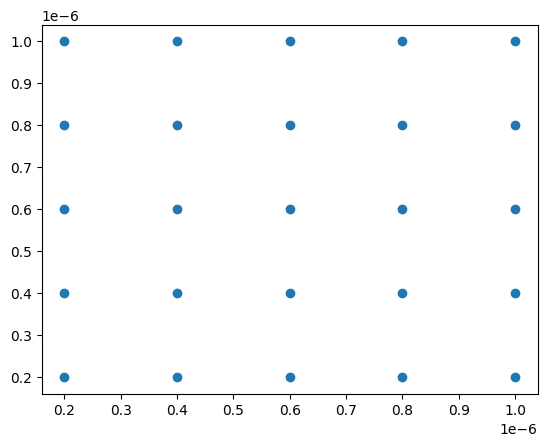

In [40]:
list_of_fet = np.array(list_of_fet)

plt.scatter(list_of_fet[:, 0], list_of_fet[:, 1])

In [41]:
# def create_model():
#     model = tf.keras.Sequential()
#     model.add(keras.layers.Dense(30, activation='tanh', input_shape=(5,)))
#     model.add(keras.layers.Dense(20, activation='tanh'))
#     model.add(keras.layers.Dense(1, activation='sigmoid'))
#     model.compile(optimizer='adam', loss='mse', metrics=['mae'])
#     # model.summary()
#     return model

In [31]:
def create_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(25, activation='relu', input_shape=(5,)))
    model.add(keras.layers.Dense(30, activation='softmax'))
    model.add(keras.layers.Dense(1, activation='tanh'))
    model.compile(optimizer='adam', loss='mape', metrics=['mse'])
    return model

In [32]:
df_val = pd.read_csv('data_val_in.csv')


def train_and_test(fet, epochs=1000, frac=1):
    database_simple = Database(
        model='tsmc018nfet',
        vd_slice = slice(0, 3.1, .5),
        vg_range = np.arange(0, 3.1, .5),
        fet_range = fet,
        t_range  = np.arange(0, 51, 25),
    )
    data = database_simple.create_dataset()
#     database_simple.to_csv('mosfet_simple.csv')

    data = ProcessDataLogNorm(data)
    
    print('Learning')
    
    model = create_model()
    model.fit(data.X_train, data.y_train, epochs=epochs, batch_size=256, shuffle=True, verbose=0)
    results = model.evaluate(data.X_test, data.y_test, batch_size=256)
    results = results[0]
    
    print('Testing')
    Xval, yval = data.transform(df_val.sample(frac=frac))
    yval = data.retransform_y(yval)
    
    y_pred = model.predict(Xval)
    y_pred = data.retransform_y(y_pred)
    
    mse = np.mean(tf.keras.metrics.mean_squared_error(yval, y_pred))
    mape = np.mean(tf.keras.metrics.mean_absolute_percentage_error(yval, y_pred))
    
    print(f'Loss train: {results}, MSE: {mse}, MAPE: {mape}')
    
    return results, mse, mape

In [28]:
from random import shuffle

In [19]:
list_of_fet = list(list_of_fet)
history_fet = []
history = []
history1 = []
history2 = []

del_fet=None

fig = plt.figure()

while len(list_of_fet) > 5:
    print('===== ', len(list_of_fet))
    results, mse, mape = train_and_test(list_of_fet, 300, 300)
    
    shuffle(list_of_fet)

    history.append(results)
    history1.append(mse)
    history2.append(mape)
    history_fet.append([results, del_fet])
    print('Deleted: ', del_fet, results, mse, mape)
    
    del_fet = list_of_fet.pop()
    
    plt.subplot(3, 1, 1)
    plt.plot(history)
    plt.subplot(3, 1, 2)
    plt.plot(history1)
    plt.subplot(3, 1, 3)
    plt.plot(history2)
    plt.savefig('history.png')

<Figure size 640x480 with 0 Axes>

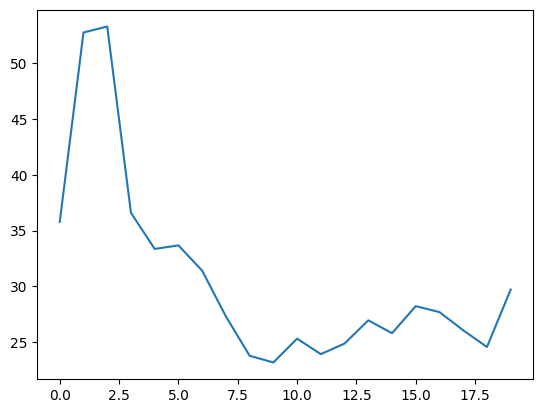

In [51]:
plt.plot(history)

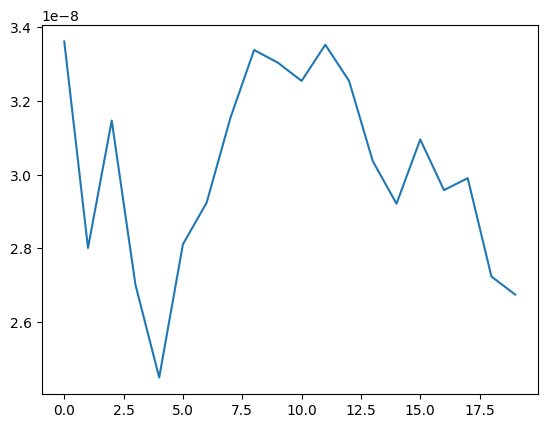

In [52]:
plt.plot(history1)

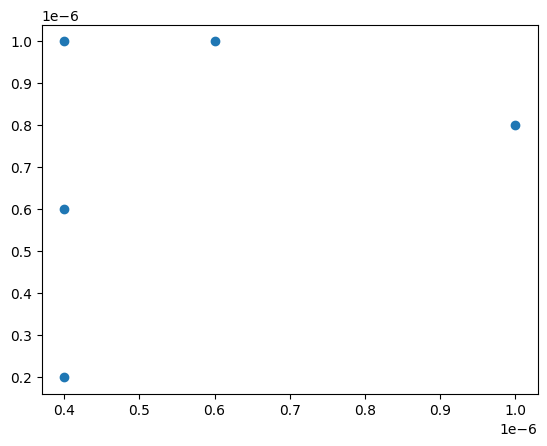

In [53]:
list_of_fet = np.array(list_of_fet)

plt.scatter(list_of_fet[:, 0], list_of_fet[:, 1])

In [15]:
list_of_fet = []
for w in np.array([200e-9, 300e-9, 400e-9, 500e-9, 600e-9, 700e-9, 800e-9, 900e-9, 1000e-9]):
    for l in np.array([200e-9, 300e-9, 400e-9, 500e-9, 600e-9, 700e-9, 800e-9, 900e-9, 1000e-9]):
        list_of_fet.append([w, l])
# print(list_of_fet)

In [58]:
# list_of_fet = []
# for w in np.array([200e-9, 400e-9, 600e-9, 800e-9, 1000e-9]):
#     for l in np.array([200e-9, 400e-9, 600e-9, 800e-9, 1000e-9]):
#         list_of_fet.append([w, l])
# print(list_of_fet)

100%|██████████████████████████████████████████████████████████████████████████████| 1701/1701 [00:35<00:00, 48.09it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 30.7869 - mse: 0.1055
Testing
17403/17403 [==============================] - 27s 2ms/step
Loss train: 30.786907196044922, MSE: 3.4646265536654856e-08, MAPE: 27573.298936445808


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:27<00:00, 60.20it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 39.5042 - mse: 0.1475
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 39.50419616699219, MSE: 2.373231854482182e-08, MAPE: 13336.572413405465
===  0 39.50419616699219 2.373231854482182e-08 13336.572413405465


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:27<00:00, 60.70it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 35.6995 - mse: 0.1342
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 35.69951248168945, MSE: 2.5624229341676503e-08, MAPE: 15908.68236367268
===  1 35.69951248168945 2.5624229341676503e-08 15908.68236367268


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:26<00:00, 63.20it/s]


Learning
10/10 [==============================] - 0s 4ms/step - loss: 46.3257 - mse: 0.1826
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 46.3256721496582, MSE: 2.025600946282089e-08, MAPE: 5546.805303010877
===  2 46.3256721496582 2.025600946282089e-08 5546.805303010877


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:26<00:00, 63.86it/s]


Learning
10/10 [==============================] - 0s 4ms/step - loss: 37.4619 - mse: 0.1626
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 37.46194839477539, MSE: 2.235707553266693e-08, MAPE: 10939.282584136783
===  3 37.46194839477539 2.235707553266693e-08 10939.282584136783


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:26<00:00, 64.07it/s]


Learning
10/10 [==============================] - 0s 4ms/step - loss: 35.4199 - mse: 0.1243
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 35.41985321044922, MSE: 2.6028043092046098e-08, MAPE: 15783.591222462544
===  4 35.41985321044922 2.6028043092046098e-08 15783.591222462544


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:28<00:00, 58.87it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 36.2990 - mse: 0.1285
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 36.29901123046875, MSE: 2.4529896163407282e-08, MAPE: 15509.261495420586
===  5 36.29901123046875 2.4529896163407282e-08 15509.261495420586


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:28<00:00, 59.52it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 34.3730 - mse: 0.1132
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 34.37303161621094, MSE: 2.3563436476056356e-08, MAPE: 14423.090538355125
===  6 34.37303161621094 2.3563436476056356e-08 14423.090538355125


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:26<00:00, 62.81it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 39.6877 - mse: 0.1387
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 39.687705993652344, MSE: 2.6042729513645418e-08, MAPE: 16805.466799301586
===  7 39.687705993652344 2.6042729513645418e-08 16805.466799301586


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:27<00:00, 61.90it/s]


Learning
10/10 [==============================] - 0s 4ms/step - loss: 38.1544 - mse: 0.1371
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 38.15439224243164, MSE: 2.2250671095947227e-08, MAPE: 9857.836823505504
===  8 38.15439224243164 2.2250671095947227e-08 9857.836823505504


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:28<00:00, 58.46it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 38.8792 - mse: 0.1326
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 38.879150390625, MSE: 2.5719897100853227e-08, MAPE: 16321.79689699268
===  9 38.879150390625 2.5719897100853227e-08 16321.79689699268


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:29<00:00, 57.76it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 59.1590 - mse: 0.1136
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 59.15901184082031, MSE: 2.6253446454615014e-08, MAPE: 18160.82018938199
===  10 59.15901184082031 2.6253446454615014e-08 18160.82018938199


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:28<00:00, 58.34it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 37.2467 - mse: 0.1298
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 37.24673843383789, MSE: 2.5164988805454625e-08, MAPE: 14079.436565067197
===  11 37.24673843383789 2.5164988805454625e-08 14079.436565067197


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:27<00:00, 61.19it/s]


Learning
10/10 [==============================] - 0s 2ms/step - loss: 40.8035 - mse: 0.1284
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 40.80354309082031, MSE: 2.4340125350261804e-08, MAPE: 13617.006262682764
===  12 40.80354309082031 2.4340125350261804e-08 13617.006262682764


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:28<00:00, 58.46it/s]


Learning
10/10 [==============================] - 0s 2ms/step - loss: 43.2107 - mse: 0.1533
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 43.210731506347656, MSE: 1.7227131596511764e-08, MAPE: 4604.067022227701
===  13 43.210731506347656 1.7227131596511764e-08 4604.067022227701


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:27<00:00, 60.38it/s]


Learning
10/10 [==============================] - 0s 4ms/step - loss: 42.1602 - mse: 0.1341
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 42.160179138183594, MSE: 1.972640780797721e-08, MAPE: 6000.852555427527
===  14 42.160179138183594 1.972640780797721e-08 6000.852555427527


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:30<00:00, 54.68it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 40.3308 - mse: 0.1493
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 40.330841064453125, MSE: 2.3975130141451236e-08, MAPE: 13338.655214362952
===  15 40.330841064453125 2.3975130141451236e-08 13338.655214362952


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:29<00:00, 56.94it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 53.0649 - mse: 0.1661
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 53.06486129760742, MSE: 2.640981080667049e-08, MAPE: 15594.688659412252
===  16 53.06486129760742 2.640981080667049e-08 15594.688659412252


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:28<00:00, 58.02it/s]


Learning
10/10 [==============================] - 0s 2ms/step - loss: 38.7626 - mse: 0.1341
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 38.76259994506836, MSE: 2.684833015876857e-08, MAPE: 16885.397996120864
===  17 38.76259994506836 2.684833015876857e-08 16885.397996120864


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:28<00:00, 58.70it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 42.7204 - mse: 0.1514
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 42.72040939331055, MSE: 1.6334358534327826e-08, MAPE: 4204.249242846861
===  18 42.72040939331055 1.6334358534327826e-08 4204.249242846861


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:28<00:00, 58.10it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 38.6671 - mse: 0.1224
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 38.667057037353516, MSE: 2.508366966829538e-08, MAPE: 15717.59759174238
===  19 38.667057037353516 2.508366966829538e-08 15717.59759174238


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:30<00:00, 55.00it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 48.3918 - mse: 0.1143
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 48.391807556152344, MSE: 2.7205223112444682e-08, MAPE: 18224.496030306927
===  20 48.391807556152344 2.7205223112444682e-08 18224.496030306927


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:32<00:00, 52.50it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 43.4953 - mse: 0.1161
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 43.49531173706055, MSE: 2.5210775877788582e-08, MAPE: 15460.43139891311
===  21 43.49531173706055 2.5210775877788582e-08 15460.43139891311


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:30<00:00, 55.37it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 43.7412 - mse: 0.1162
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 43.741180419921875, MSE: 2.6296945519526162e-08, MAPE: 16927.84602545844
===  22 43.741180419921875 2.6296945519526162e-08 16927.84602545844


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:29<00:00, 56.01it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 40.2541 - mse: 0.1445
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 40.2541389465332, MSE: 2.289700655872411e-08, MAPE: 12952.06692659274
===  23 40.2541389465332 2.289700655872411e-08 12952.06692659274


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:32<00:00, 52.20it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 41.0226 - mse: 0.1620
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 41.02260971069336, MSE: 2.1708740638699313e-08, MAPE: 11784.323169687756
===  24 41.02260971069336 2.1708740638699313e-08 11784.323169687756


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:29<00:00, 56.26it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 46.4772 - mse: 0.1868
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 46.47719192504883, MSE: 1.8862380123956756e-08, MAPE: 4665.9860807911755
===  25 46.47719192504883 1.8862380123956756e-08 4665.9860807911755


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:30<00:00, 54.35it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 39.6044 - mse: 0.1524
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 39.604400634765625, MSE: 1.9615503333829524e-08, MAPE: 6659.881308233001
===  26 39.604400634765625 1.9615503333829524e-08 6659.881308233001


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:31<00:00, 54.09it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 35.7237 - mse: 0.1164
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 35.72370910644531, MSE: 2.4426926627647374e-08, MAPE: 15257.85884784939
===  27 35.72370910644531 2.4426926627647374e-08 15257.85884784939


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:31<00:00, 53.86it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 35.3068 - mse: 0.1154
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 35.30680847167969, MSE: 2.3323259207479678e-08, MAPE: 13345.600669631214
===  28 35.30680847167969 2.3323259207479678e-08 13345.600669631214


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:32<00:00, 50.92it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 39.8267 - mse: 0.1347
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 39.82673645019531, MSE: 2.6195238896045788e-08, MAPE: 16141.13171204237
===  29 39.82673645019531 2.6195238896045788e-08 16141.13171204237


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:33<00:00, 50.73it/s]


Learning
10/10 [==============================] - 0s 2ms/step - loss: 56.0341 - mse: 0.1131
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 56.034088134765625, MSE: 2.5906203803310915e-08, MAPE: 17525.062408223916
===  30 56.034088134765625 2.5906203803310915e-08 17525.062408223916


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:32<00:00, 50.96it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 47.0423 - mse: 0.1200
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 47.04228210449219, MSE: 2.5053413700500193e-08, MAPE: 16012.25295978409
===  31 47.04228210449219 2.5053413700500193e-08 16012.25295978409


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:33<00:00, 50.07it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 39.7582 - mse: 0.1162
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 39.758216857910156, MSE: 2.4430634476360968e-08, MAPE: 15449.48202647584
===  32 39.758216857910156 2.4430634476360968e-08 15449.48202647584


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:32<00:00, 51.97it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 41.6511 - mse: 0.1179
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 41.6511116027832, MSE: 2.6571155522107704e-08, MAPE: 16935.897007519554
===  33 41.6511116027832 2.6571155522107704e-08 16935.897007519554


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:32<00:00, 51.00it/s]


Learning
10/10 [==============================] - 0s 2ms/step - loss: 38.8974 - mse: 0.1309
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 38.89735794067383, MSE: 2.280962685367654e-08, MAPE: 12405.064115277324
===  34 38.89735794067383 2.280962685367654e-08 12405.064115277324


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:31<00:00, 52.67it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 38.1442 - mse: 0.1279
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 38.144203186035156, MSE: 1.9962607884579587e-08, MAPE: 9052.783823168471
===  35 38.144203186035156 1.9962607884579587e-08 9052.783823168471


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:32<00:00, 52.47it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 38.8564 - mse: 0.1400
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 38.85642623901367, MSE: 2.227973217805462e-08, MAPE: 11587.313652700002
===  36 38.85642623901367 2.227973217805462e-08 11587.313652700002


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:32<00:00, 52.04it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 67.2473 - mse: 0.4012
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 67.24734497070312, MSE: 1.945859986075384e-08, MAPE: 8096.883455557582
===  37 67.24734497070312 1.945859986075384e-08 8096.883455557582


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:33<00:00, 50.06it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 41.7564 - mse: 0.1236
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 41.756378173828125, MSE: 2.5364588093107046e-08, MAPE: 15451.800759241753
===  38 41.756378173828125 2.5364588093107046e-08 15451.800759241753


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:32<00:00, 51.35it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 38.2542 - mse: 0.1191
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 38.254150390625, MSE: 2.518453195244941e-08, MAPE: 16026.05503657188
===  39 38.254150390625 2.518453195244941e-08 16026.05503657188


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:34<00:00, 48.46it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 43.0520 - mse: 0.1135
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 43.052005767822266, MSE: 2.5607863168355682e-08, MAPE: 16938.54901946975
===  40 43.052005767822266 2.5607863168355682e-08 16938.54901946975


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:33<00:00, 50.77it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 147.6535 - mse: 0.1184
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 147.65347290039062, MSE: 2.54714229199491e-08, MAPE: 16130.952850692744
===  41 147.65347290039062 2.54714229199491e-08 16130.952850692744


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:33<00:00, 50.08it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 55.1401 - mse: 0.1425
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 55.140140533447266, MSE: 2.8127610708100956e-08, MAPE: 19122.47443066004
===  42 55.140140533447266 2.8127610708100956e-08 19122.47443066004


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:34<00:00, 49.30it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 47.1434 - mse: 0.1129
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 47.14344024658203, MSE: 2.726940751993966e-08, MAPE: 18556.05613831175
===  43 47.14344024658203 2.726940751993966e-08 18556.05613831175


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:36<00:00, 46.09it/s]


Learning
10/10 [==============================] - 0s 2ms/step - loss: 42.8856 - mse: 0.1179
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 42.8856086730957, MSE: 2.5970403865286954e-08, MAPE: 15201.276830109997
===  44 42.8856086730957 2.5970403865286954e-08 15201.276830109997


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:33<00:00, 49.43it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 37.5172 - mse: 0.1438
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 37.51716995239258, MSE: 2.2073021639448543e-08, MAPE: 12423.031791280118
===  45 37.51716995239258 2.2073021639448543e-08 12423.031791280118


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:34<00:00, 48.17it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 37.3161 - mse: 0.1269
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 37.31608963012695, MSE: 2.124483594852469e-08, MAPE: 10589.765789882083
===  46 37.31608963012695 2.124483594852469e-08 10589.765789882083


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:34<00:00, 49.16it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 42.8180 - mse: 0.1449
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 42.81801223754883, MSE: 2.045368166162673e-08, MAPE: 10721.932063742133
===  47 42.81801223754883 2.045368166162673e-08 10721.932063742133


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:35<00:00, 47.54it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 43.7693 - mse: 0.1313
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 43.76926803588867, MSE: 2.4252872761755134e-08, MAPE: 14813.141365423835
===  48 43.76926803588867 2.4252872761755134e-08 14813.141365423835


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:34<00:00, 48.75it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 36.5334 - mse: 0.1327
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 36.53342056274414, MSE: 2.4548168981919013e-08, MAPE: 14975.124748090819
===  49 36.53342056274414 2.4548168981919013e-08 14975.124748090819


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:34<00:00, 48.27it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 42.9686 - mse: 0.1209
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 42.968631744384766, MSE: 2.4822327862562936e-08, MAPE: 16173.140972193132
===  50 42.968631744384766 2.4822327862562936e-08 16173.140972193132


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:36<00:00, 45.60it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 80.8237 - mse: 0.1113
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 80.82366943359375, MSE: 2.7533360469635444e-08, MAPE: 18497.487103469946
===  51 80.82366943359375 2.7533360469635444e-08 18497.487103469946


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:35<00:00, 47.60it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 170.3526 - mse: 0.1264
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 170.35264587402344, MSE: 2.678446147861062e-08, MAPE: 18073.684296508032
===  52 170.35264587402344 2.678446147861062e-08 18073.684296508032


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:35<00:00, 47.52it/s]


Learning
10/10 [==============================] - 0s 4ms/step - loss: 39.9880 - mse: 0.1260
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 39.988033294677734, MSE: 2.5621811055636034e-08, MAPE: 16812.719285785406
===  53 39.988033294677734 2.5621811055636034e-08 16812.719285785406


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:35<00:00, 47.11it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 39.3036 - mse: 0.1249
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 39.3035774230957, MSE: 2.4021441177154544e-08, MAPE: 15000.411201058525
===  54 39.3035774230957 2.4021441177154544e-08 15000.411201058525


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:35<00:00, 46.96it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 38.3484 - mse: 0.1657
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 38.34842300415039, MSE: 2.283578235987664e-08, MAPE: 12140.166563629164
===  55 38.34842300415039 2.283578235987664e-08 12140.166563629164


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:35<00:00, 46.67it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 42.8437 - mse: 0.1742
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 42.84372329711914, MSE: 1.813633273569173e-08, MAPE: 3764.609254829623
===  56 42.84372329711914 1.813633273569173e-08 3764.609254829623


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:36<00:00, 46.49it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 38.6678 - mse: 0.1348
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 38.66783142089844, MSE: 2.1178035973378424e-08, MAPE: 11650.935802208585
===  57 38.66783142089844 2.1178035973378424e-08 11650.935802208585


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:36<00:00, 45.78it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 46.7885 - mse: 0.1211
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 46.78850173950195, MSE: 2.4578675296600918e-08, MAPE: 14772.24732181927
===  58 46.78850173950195 2.4578675296600918e-08 14772.24732181927


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:36<00:00, 46.08it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 41.0809 - mse: 0.1382
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 41.08087921142578, MSE: 2.5496601453653746e-08, MAPE: 17225.461694511956
===  59 41.08087921142578 2.5496601453653746e-08 17225.461694511956


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:37<00:00, 44.59it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 42.0739 - mse: 0.1323
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 42.07392120361328, MSE: 2.4844546540501987e-08, MAPE: 15432.534258621248
===  60 42.07392120361328 2.4844546540501987e-08 15432.534258621248


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:36<00:00, 45.57it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 41.5359 - mse: 0.1123
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 41.53593444824219, MSE: 2.6011727370679783e-08, MAPE: 18513.254798867896
===  61 41.53593444824219 2.6011727370679783e-08 18513.254798867896


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:37<00:00, 44.85it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 72.1038 - mse: 0.1377
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 72.10377502441406, MSE: 2.774059135270695e-08, MAPE: 18990.696027342798
===  62 72.10377502441406 2.774059135270695e-08 18990.696027342798


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:37<00:00, 45.03it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 35.6185 - mse: 0.1343
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 35.61845397949219, MSE: 2.472269023426191e-08, MAPE: 15846.790237922349
===  63 35.61845397949219 2.472269023426191e-08 15846.790237922349


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:37<00:00, 44.86it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 46.1857 - mse: 0.3650
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 46.18567657470703, MSE: 1.6432630898160005e-08, MAPE: 2418.2730804496396
===  64 46.18567657470703 1.6432630898160005e-08 2418.2730804496396


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:37<00:00, 44.92it/s]


Learning
10/10 [==============================] - 0s 2ms/step - loss: 35.5084 - mse: 0.1219
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 35.50844192504883, MSE: 2.204157928458897e-08, MAPE: 11965.88791796664
===  65 35.50844192504883 2.204157928458897e-08 11965.88791796664


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:38<00:00, 43.47it/s]


Learning
10/10 [==============================] - 0s 2ms/step - loss: 45.0287 - mse: 0.1821
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 45.02873229980469, MSE: 1.6936236338566258e-08, MAPE: 5342.424730219482
===  66 45.02873229980469 1.6936236338566258e-08 5342.424730219482


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:38<00:00, 44.00it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 40.2525 - mse: 0.1249
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 40.25252151489258, MSE: 2.3476216438435027e-08, MAPE: 13202.635348028844
===  67 40.25252151489258 2.3476216438435027e-08 13202.635348028844


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:38<00:00, 43.94it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 38.4988 - mse: 0.1209
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 38.49879837036133, MSE: 2.566444649713258e-08, MAPE: 16048.586386989413
===  68 38.49879837036133 2.566444649713258e-08 16048.586386989413


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:38<00:00, 43.71it/s]


Learning
10/10 [==============================] - 0s 2ms/step - loss: 35.7463 - mse: 0.1234
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 35.74628829956055, MSE: 2.541393440151982e-08, MAPE: 16663.437057620627
===  69 35.74628829956055 2.541393440151982e-08 16663.437057620627


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:38<00:00, 43.16it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 35.7980 - mse: 0.1217
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 35.79798889160156, MSE: 2.478474132496825e-08, MAPE: 15733.070561858669
===  70 35.79798889160156 2.478474132496825e-08 15733.070561858669


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:39<00:00, 43.04it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 46.5362 - mse: 0.1170
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 46.536216735839844, MSE: 2.6169014391321667e-08, MAPE: 17038.018953594434
===  71 46.536216735839844 2.6169014391321667e-08 17038.018953594434


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:39<00:00, 42.99it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 35.9341 - mse: 0.1170
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 35.934112548828125, MSE: 2.3098202101738802e-08, MAPE: 13515.472952026299
===  72 35.934112548828125 2.3098202101738802e-08 13515.472952026299


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:40<00:00, 41.64it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 45.6961 - mse: 0.1417
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 45.69610595703125, MSE: 2.2148707230220837e-08, MAPE: 11622.25454965342
===  73 45.69610595703125 2.2148707230220837e-08 11622.25454965342


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:39<00:00, 42.44it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 39.6266 - mse: 0.1529
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 39.6265869140625, MSE: 2.2790548970912e-08, MAPE: 14196.818564950012
===  74 39.6265869140625 2.2790548970912e-08 14196.818564950012


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:40<00:00, 41.54it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 42.5485 - mse: 0.1570
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 42.54854202270508, MSE: 1.9721199413246582e-08, MAPE: 9490.148983807374
===  75 42.54854202270508 1.9721199413246582e-08 9490.148983807374


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:39<00:00, 42.24it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 47.8021 - mse: 0.2443
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 47.802085876464844, MSE: 1.8612157791529908e-08, MAPE: 7454.6292945881705
===  76 47.802085876464844 1.8612157791529908e-08 7454.6292945881705


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:40<00:00, 41.84it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 35.2383 - mse: 0.1155
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 35.23826217651367, MSE: 2.5337241704832812e-08, MAPE: 13992.606586793816
===  77 35.23826217651367 2.5337241704832812e-08 13992.606586793816


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:40<00:00, 41.61it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 40.3363 - mse: 0.1370
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 40.33633804321289, MSE: 2.6719181265319095e-08, MAPE: 17980.86162401215
===  78 40.33633804321289 2.6719181265319095e-08 17980.86162401215


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:47<00:00, 35.68it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 44.0419 - mse: 0.1247
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 44.041893005371094, MSE: 2.4282845004733144e-08, MAPE: 14840.892941740049
===  79 44.041893005371094 2.4282845004733144e-08 14840.892941740049


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:41<00:00, 40.33it/s]


Learning
10/10 [==============================] - 0s 3ms/step - loss: 41.5395 - mse: 0.1239
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 41.539512634277344, MSE: 2.534968546709382e-08, MAPE: 16601.291593303402
===  80 41.539512634277344 2.534968546709382e-08 16601.291593303402
[(170.35264587402344, [7e-07, 9e-07]), (147.65347290039062, [6e-07, 7e-07]), (80.82366943359375, [7e-07, 8e-07]), (72.10377502441406, [8e-07, 1e-06]), (67.24734497070312, [6e-07, 3e-07]), (59.15901184082031, [3e-07, 3e-07]), (56.034088134765625, [5e-07, 5e-07]), (55.140140533447266, [6e-07, 8e-07]), (53.06486129760742, [3e-07, 9e-07]), (48.391807556152344, [4e-07, 4e-07]), (47.802085876464844, [1e-06, 6e-07]), (47.14344024658203, [6e-07, 9e-07]), (47.04228210449219, [5e-07, 6e-07]), (46.78850173950195, [8e-07, 6e-07]), (46.536216735839844, [9e-07, 1e-06]), (46.47719192504883, [4e-07, 9e-07]), (46.3256721496582, [2e-07, 4e-07]), (46.18567657470703, [9e-07, 3e-07]), (45.6961059570312

100%|██████████████████████████████████████████████████████████████████████████████| 1596/1596 [00:39<00:00, 40.73it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 34.5553 - mse: 0.1146
Testing
17403/17403 [==============================] - 31s 2ms/step
Loss train: 34.55529022216797, MSE: 3.2722646207807014e-08, MAPE: 26768.11809089432


TypeError: scatter() missing 1 required positional argument: 'y'

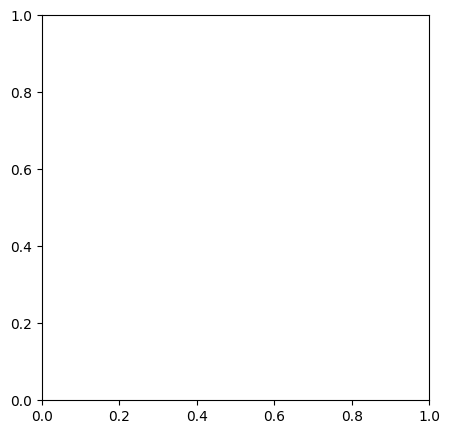

In [22]:
list_of_fet = list(list_of_fet)
history = []
history1 = []

loss, mse, mape = train_and_test(list_of_fet)
history.append([loss, mse, mape])

fig, ax = plt.subplots(figsize=(5,5))

for _ in range(1):
    matrix = []
    
    for i in range(len(list_of_fet)):
        lst = list_of_fet.copy()
        fet = lst.pop(i)
        
        loss, mse, mape = train_and_test(lst, 100, 0.1)
        print('=== ', i, loss, mse, mape)
        
        matrix.append((loss, fet))
    
        
    history1.append((fet, loss, mse, mape))
    matrix.sort(key=lambda x: -x[0])
    print(matrix)
    matrix = matrix[5:]
    
    list_of_fet = []
    for _, x in matrix:
        list_of_fet.append(x)
        
    loss, mse, mape = train_and_test(list_of_fet)
    history.append([loss, mse, mape])
        
    ax.clear()
    ax.scatter(list_of_fet)
    fig.canvas.draw()

In [23]:
history

[[30.786907196044922, 3.4646265536654856e-08, 27573.298936445808],
 [34.55529022216797, 3.2722646207807014e-08, 26768.11809089432]]

In [16]:
# history = [[30.786907196044922, 3.4646265536654856e-08, 27573.298936445808],
#  [34.55529022216797, 3.2722646207807014e-08, 26768.11809089432]]

In [24]:
history1

[([1e-06, 1e-06],
  41.539512634277344,
  2.534968546709382e-08,
  16601.291593303402)]

In [17]:
# history1 = [([1e-06, 1e-06],
#   41.539512634277344,
#   2.534968546709382e-08,
#   16601.291593303402)]

In [35]:
# list_of_fet = [[4e-07, 4e-07], [3e-07, 3e-07], [6e-07, 8e-07], [5e-07, 5e-07], [8e-07, 9e-07], [6e-07, 6e-07], [9e-07, 1e-06], [7e-07, 1e-06], [4e-07, 5e-07], [6e-07, 9e-07], [8e-07, 8e-07], [5e-07, 7e-07], [5e-07, 4e-07], [7e-07, 7e-07], [3e-07, 4e-07], [6e-07, 1e-06], [4e-07, 6e-07], [4e-07, 8e-07], [9e-07, 9e-07], [1e-06, 1e-06], [5e-07, 9e-07], [3e-07, 5e-07], [4e-07, 7e-07], [7e-07, 6e-07], [6e-07, 4e-07], [9e-07, 7e-07], [1e-06, 8e-07], [5e-07, 8e-07], [6e-07, 5e-07], [8e-07, 7e-07], [2e-07, 2e-07], [3e-07, 7e-07], [9e-07, 8e-07], [2e-07, 9e-07], [1e-06, 9e-07], [4e-07, 1e-06], [8e-07, 6e-07], [3e-07, 9e-07], [3e-07, 1e-06], [5e-07, 1e-06], [4e-07, 9e-07], [7e-07, 5e-07], [9e-07, 5e-07], [1e-06, 7e-07], [3e-07, 2e-07], [8e-07, 5e-07], [4e-07, 3e-07], [6e-07, 2e-07], [3e-07, 6e-07], [3e-07, 8e-07], [1e-06, 5e-07], [7e-07, 4e-07], [2e-07, 3e-07], [2e-07, 6e-07], [9e-07, 6e-07], [1e-06, 4e-07], [1e-06, 6e-07], [1e-06, 2e-07], [2e-07, 4e-07], [2e-07, 7e-07], [5e-07, 3e-07], [6e-07, 3e-07], [2e-07, 5e-07], [4e-07, 2e-07], [9e-07, 4e-07], [1e-06, 3e-07], [8e-07, 4e-07], [2e-07, 8e-07], [8e-07, 3e-07], [7e-07, 3e-07], [5e-07, 2e-07], [8e-07, 2e-07], [7e-07, 2e-07], [9e-07, 3e-07], [9e-07, 2e-07], [2e-07, 1e-06]]

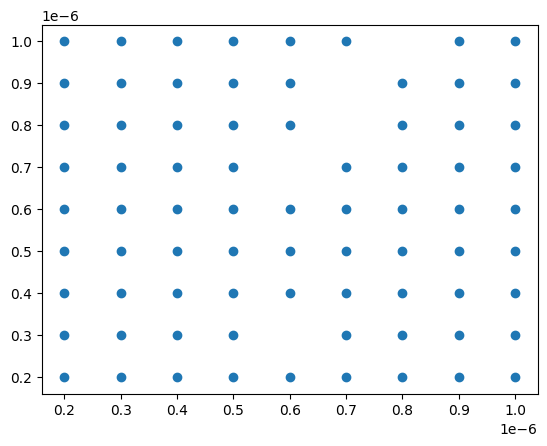

In [26]:
list_of_fet = np.array(list_of_fet)

plt.scatter(list_of_fet[:, 0], list_of_fet[:, 1])

100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:39<00:00, 39.39it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 39.6442 - mse: 0.1197
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 39.64423370361328, MSE: 2.3825442873003178e-08, MAPE: 12780.657246112281
0 39.64423370361328 2.3825442873003178e-08 12780.657246112281


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:40<00:00, 39.26it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 43.4581 - mse: 0.1753
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 43.45805740356445, MSE: 2.357896858250105e-08, MAPE: 12261.272243705416
1 43.45805740356445 2.357896858250105e-08 12261.272243705416


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:41<00:00, 38.13it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 46.9709 - mse: 0.1112
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 46.97091293334961, MSE: 2.6599622167992417e-08, MAPE: 20052.466319010215
2 46.97091293334961 2.6599622167992417e-08 20052.466319010215


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:42<00:00, 36.94it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 39.8185 - mse: 0.1176
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 39.81853103637695, MSE: 2.6640351713379412e-08, MAPE: 18462.195080741247
3 39.81853103637695 2.6640351713379412e-08 18462.195080741247


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:42<00:00, 36.63it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 41.1837 - mse: 0.1154
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 41.183650970458984, MSE: 2.5559324985068396e-08, MAPE: 16363.759984371121
4 41.183650970458984 2.5559324985068396e-08 16363.759984371121


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:42<00:00, 37.13it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 47.5120 - mse: 0.1090
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 47.51203918457031, MSE: 2.8114596507677364e-08, MAPE: 21374.67843624683
5 47.51203918457031 2.8114596507677364e-08 21374.67843624683


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:41<00:00, 37.62it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 45.9783 - mse: 0.1145
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 45.97825622558594, MSE: 2.7126876121546775e-08, MAPE: 19552.64391579558
6 45.97825622558594 2.7126876121546775e-08 19552.64391579558


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:40<00:00, 39.16it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 41.6614 - mse: 0.1178
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 41.66139602661133, MSE: 2.685239522430362e-08, MAPE: 19947.40058645806
7 41.66139602661133 2.685239522430362e-08 19947.40058645806


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:40<00:00, 39.33it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 37.6382 - mse: 0.1195
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 37.638221740722656, MSE: 3.0188517344050074e-08, MAPE: 22348.75945679695
8 37.638221740722656 3.0188517344050074e-08 22348.75945679695


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:40<00:00, 38.90it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 39.2439 - mse: 0.1319
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 39.243919372558594, MSE: 1.857205825050675e-08, MAPE: 4905.243249968325
9 39.243919372558594 1.857205825050675e-08 4905.243249968325


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:40<00:00, 38.84it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 47.9058 - mse: 0.1121
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 47.905826568603516, MSE: 3.04477886923351e-08, MAPE: 22435.31321040125
10 47.905826568603516 3.04477886923351e-08 22435.31321040125


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:40<00:00, 38.94it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 51.8708 - mse: 0.1092
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 51.87077331542969, MSE: 2.8413617647543426e-08, MAPE: 21166.124295974936
11 51.87077331542969 2.8413617647543426e-08 21166.124295974936


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:40<00:00, 38.91it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 44.5784 - mse: 0.1240
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 44.5783805847168, MSE: 2.4640535675358734e-08, MAPE: 17121.51482070969
12 44.5783805847168 2.4640535675358734e-08 17121.51482070969


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:41<00:00, 37.79it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 43.4218 - mse: 0.1315
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 43.4217643737793, MSE: 2.333098172394006e-08, MAPE: 11764.764222992324
13 43.4217643737793 2.333098172394006e-08 11764.764222992324


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:40<00:00, 38.61it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 51.2710 - mse: 0.1107
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 51.270973205566406, MSE: 2.7239051111050085e-08, MAPE: 20182.926996459944
14 51.270973205566406 2.7239051111050085e-08 20182.926996459944


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:41<00:00, 38.40it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 38.1967 - mse: 0.1170
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 38.196746826171875, MSE: 2.6021458066199975e-08, MAPE: 18328.932203140135
15 38.196746826171875 2.6021458066199975e-08 18328.932203140135


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:41<00:00, 38.31it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 39.0345 - mse: 0.1313
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 39.034454345703125, MSE: 2.6362682742834726e-08, MAPE: 18235.648570225836
16 39.034454345703125 2.6362682742834726e-08 18235.648570225836


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:41<00:00, 38.17it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 52.1489 - mse: 0.1114
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 52.14888000488281, MSE: 2.9390918564368876e-08, MAPE: 20683.75538770232
17 52.14888000488281 2.9390918564368876e-08 20683.75538770232


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:41<00:00, 38.02it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 53.3946 - mse: 0.1225
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 53.394622802734375, MSE: 2.9521613156227713e-08, MAPE: 23859.00307297777
18 53.394622802734375 2.9521613156227713e-08 23859.00307297777


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:41<00:00, 37.88it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 43.0649 - mse: 0.1242
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 43.064918518066406, MSE: 3.023684874676477e-08, MAPE: 22502.63442428813
19 43.064918518066406 3.023684874676477e-08 22502.63442428813


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:41<00:00, 37.86it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 40.1795 - mse: 0.1348
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 40.179542541503906, MSE: 2.181989421802259e-08, MAPE: 7511.464834926133
20 40.179542541503906 2.181989421802259e-08 7511.464834926133


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:41<00:00, 37.64it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 42.0366 - mse: 0.1176
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 42.03661346435547, MSE: 2.381119178462149e-08, MAPE: 14137.396878398005
21 42.03661346435547 2.381119178462149e-08 14137.396878398005


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:42<00:00, 37.38it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 64.0792 - mse: 0.1120
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 64.07923889160156, MSE: 2.786298317305652e-08, MAPE: 21064.077795995923
22 64.07923889160156 2.786298317305652e-08 21064.077795995923


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:42<00:00, 37.24it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 73.7374 - mse: 0.1151
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 73.73738098144531, MSE: 2.6975326407538954e-08, MAPE: 19156.935541695966
23 73.73738098144531 2.6975326407538954e-08 19156.935541695966


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:42<00:00, 37.16it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 41.1290 - mse: 0.1116
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 41.12898254394531, MSE: 2.8846156249258423e-08, MAPE: 22406.354234226714
24 41.12898254394531 2.8846156249258423e-08 22406.354234226714


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:42<00:00, 37.00it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 64.2733 - mse: 0.1146
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 64.27334594726562, MSE: 2.851459840010849e-08, MAPE: 21589.665198015133
25 64.27334594726562 2.851459840010849e-08 21589.665198015133


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:42<00:00, 36.93it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 390.8933 - mse: 0.1108
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 390.8932800292969, MSE: 3.0000292972012875e-08, MAPE: 22966.2359363413
26 390.8932800292969 3.0000292972012875e-08 22966.2359363413


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:42<00:00, 37.30it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 41.1511 - mse: 0.1156
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 41.151058197021484, MSE: 2.7429712512214577e-08, MAPE: 19131.0880900524
27 41.151058197021484 2.7429712512214577e-08 19131.0880900524


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:42<00:00, 37.08it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 48.7261 - mse: 0.2154
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 48.72608947753906, MSE: 2.3013800689416774e-08, MAPE: 14494.579710795035
28 48.72608947753906 2.3013800689416774e-08 14494.579710795035


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:42<00:00, 36.81it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 42.0747 - mse: 0.1156
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 42.07472229003906, MSE: 2.6825701043051553e-08, MAPE: 19243.13745164521
29 42.07472229003906 2.6825701043051553e-08 19243.13745164521


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:42<00:00, 36.87it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 50.4995 - mse: 0.1204
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 50.49953079223633, MSE: 2.994684798962947e-08, MAPE: 22096.305191104122
30 50.49953079223633 2.994684798962947e-08 22096.305191104122


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:42<00:00, 36.71it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 37.2846 - mse: 0.1263
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 37.284610748291016, MSE: 2.6316016674308355e-08, MAPE: 18899.60990655253
31 37.284610748291016 2.6316016674308355e-08 18899.60990655253


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:43<00:00, 36.29it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 40.9751 - mse: 0.1313
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 40.975059509277344, MSE: 2.127602014702355e-08, MAPE: 9804.135026024207
32 40.975059509277344 2.127602014702355e-08 9804.135026024207


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:43<00:00, 36.08it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 39.2452 - mse: 0.1255
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 39.24516296386719, MSE: 2.56497967175429e-08, MAPE: 17690.178353635318
33 39.24516296386719 2.56497967175429e-08 17690.178353635318


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:43<00:00, 36.17it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 47.1441 - mse: 0.1180
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 47.144142150878906, MSE: 2.975723174703098e-08, MAPE: 21863.17630469124
34 47.144142150878906 2.975723174703098e-08 21863.17630469124


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:43<00:00, 35.88it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 95.7438 - mse: 0.1123
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 95.74378204345703, MSE: 2.6935647754815518e-08, MAPE: 19239.74659684062
35 95.74378204345703 2.6935647754815518e-08 19239.74659684062


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:43<00:00, 35.97it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 37.3357 - mse: 0.1294
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 37.335731506347656, MSE: 2.906263484083721e-08, MAPE: 20402.300971396493
36 37.335731506347656 2.906263484083721e-08 20402.300971396493


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:44<00:00, 35.51it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 42.4023 - mse: 0.1118
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 42.4023323059082, MSE: 2.6876944270779693e-08, MAPE: 19685.76011049466
37 42.4023323059082 2.6876944270779693e-08 19685.76011049466


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:44<00:00, 35.02it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 235.4647 - mse: 0.1148
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 235.46470642089844, MSE: 2.762470537665414e-08, MAPE: 20343.222575431242
38 235.46470642089844 2.762470537665414e-08 20343.222575431242


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:44<00:00, 35.12it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 41.8611 - mse: 0.1114
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 41.86110305786133, MSE: 3.06517152630476e-08, MAPE: 22726.16461049757
39 41.86110305786133 3.06517152630476e-08 22726.16461049757


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:45<00:00, 34.66it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 46.0387 - mse: 0.1167
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 46.03872299194336, MSE: 2.5412534644793042e-08, MAPE: 17694.456089310162
40 46.03872299194336 2.5412534644793042e-08 17694.456089310162


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:45<00:00, 34.45it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 40.9849 - mse: 0.1181
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 40.98488998413086, MSE: 2.566633426045278e-08, MAPE: 16283.223766899293
41 40.98488998413086 2.566633426045278e-08 16283.223766899293


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:46<00:00, 33.59it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 48.0857 - mse: 0.1161
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 48.08565902709961, MSE: 2.668822257927764e-08, MAPE: 18853.916183594618
42 48.08565902709961 2.668822257927764e-08 18853.916183594618


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:45<00:00, 34.31it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 44.2074 - mse: 0.1187
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 44.20738220214844, MSE: 2.7913558029519382e-08, MAPE: 20695.06707479031
43 44.20738220214844 2.7913558029519382e-08 20695.06707479031


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:45<00:00, 34.45it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 56.5100 - mse: 0.1065
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 56.50996398925781, MSE: 2.971824659115556e-08, MAPE: 22435.77369959321
44 56.50996398925781 2.971824659115556e-08 22435.77369959321


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:46<00:00, 34.17it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 39.7178 - mse: 0.1183
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 39.71784210205078, MSE: 2.843559040632414e-08, MAPE: 22291.789131271536
45 39.71784210205078 2.843559040632414e-08 22291.789131271536


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:46<00:00, 34.04it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 38.0070 - mse: 0.1308
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 38.00701904296875, MSE: 2.525191414501318e-08, MAPE: 16254.358465900843
46 38.00701904296875 2.525191414501318e-08 16254.358465900843


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:46<00:00, 33.83it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 49.8994 - mse: 0.1123
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 49.89936065673828, MSE: 2.8913806292617012e-08, MAPE: 22404.453938599192
47 49.89936065673828 2.8913806292617012e-08 22404.453938599192


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:46<00:00, 33.64it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 758.3572 - mse: 0.1144
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 758.3572387695312, MSE: 2.8524746612038126e-08, MAPE: 21207.766791711263
48 758.3572387695312 2.8524746612038126e-08 21207.766791711263


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:46<00:00, 33.56it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 39.8593 - mse: 0.1228
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 39.85926818847656, MSE: 2.6486345358955133e-08, MAPE: 19662.7512551121
49 39.85926818847656 2.6486345358955133e-08 19662.7512551121


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:46<00:00, 33.70it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 43.4738 - mse: 0.1150
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 43.47380065917969, MSE: 2.732787468398613e-08, MAPE: 21059.68772199181
50 43.47380065917969 2.732787468398613e-08 21059.68772199181


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:46<00:00, 33.55it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 40.1969 - mse: 0.1207
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 40.196929931640625, MSE: 2.868886822028441e-08, MAPE: 18339.46304650773
51 40.196929931640625 2.868886822028441e-08 18339.46304650773


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:47<00:00, 33.39it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 40.2180 - mse: 0.1170
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 40.21800994873047, MSE: 2.931893058978735e-08, MAPE: 21471.988568192504
52 40.21800994873047 2.931893058978735e-08 21471.988568192504


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:47<00:00, 33.43it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 39.5736 - mse: 0.1201
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 39.5736198425293, MSE: 2.7099979222311203e-08, MAPE: 20460.359064876386
53 39.5736198425293 2.7099979222311203e-08 20460.359064876386


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:47<00:00, 33.42it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 38.4118 - mse: 0.1184
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 38.41179275512695, MSE: 2.520091355394757e-08, MAPE: 17909.9398107479
54 38.41179275512695 2.520091355394757e-08 17909.9398107479


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:47<00:00, 33.22it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 38.3404 - mse: 0.1273
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 38.34042739868164, MSE: 2.8541147865154282e-08, MAPE: 22066.1968470358
55 38.34042739868164 2.8541147865154282e-08 22066.1968470358


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:47<00:00, 33.16it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 44.1560 - mse: 0.1159
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 44.155975341796875, MSE: 3.1267591351430024e-08, MAPE: 23400.891405948
56 44.155975341796875 3.1267591351430024e-08 23400.891405948


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:47<00:00, 32.93it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 32.0843 - mse: 0.1157
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 32.08433532714844, MSE: 2.9074095453451223e-08, MAPE: 20029.129000259953
57 32.08433532714844 2.9074095453451223e-08 20029.129000259953


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:47<00:00, 32.86it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 35.1662 - mse: 0.1345
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 35.166236877441406, MSE: 2.2005912664172434e-08, MAPE: 10628.40557610208
58 35.166236877441406 2.2005912664172434e-08 10628.40557610208


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:47<00:00, 32.81it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 55.2973 - mse: 0.1151
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 55.29726028442383, MSE: 2.7835759404186525e-08, MAPE: 21295.42425377279
59 55.29726028442383 2.7835759404186525e-08 21295.42425377279


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:48<00:00, 32.73it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 32.4758 - mse: 0.1190
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 32.47582244873047, MSE: 2.5749796599720843e-08, MAPE: 17912.093823074563
60 32.47582244873047 2.5749796599720843e-08 17912.093823074563


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:48<00:00, 32.57it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 35.7200 - mse: 0.1279
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 35.72003936767578, MSE: 2.522927663279842e-08, MAPE: 16253.691590107286
61 35.72003936767578 2.522927663279842e-08 16253.691590107286


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:48<00:00, 32.41it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 34.0972 - mse: 0.1230
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 34.097206115722656, MSE: 2.45139817454054e-08, MAPE: 14821.806480816193
62 34.097206115722656 2.45139817454054e-08 14821.806480816193


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:48<00:00, 32.30it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 33.7415 - mse: 0.1268
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 33.74148178100586, MSE: 2.4537509948263122e-08, MAPE: 15320.387742271387
63 33.74148178100586 2.4537509948263122e-08 15320.387742271387


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:49<00:00, 32.09it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 32.9641 - mse: 0.1189
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 32.96414566040039, MSE: 2.4945067075703283e-08, MAPE: 14605.205740832294
64 32.96414566040039 2.4945067075703283e-08 14605.205740832294


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:49<00:00, 32.06it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 35.3915 - mse: 0.1128
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 35.391510009765625, MSE: 2.747642369133124e-08, MAPE: 18802.414337251153
65 35.391510009765625 2.747642369133124e-08 18802.414337251153


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:49<00:00, 31.90it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 34.6246 - mse: 0.1272
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 34.62458038330078, MSE: 2.569781795930798e-08, MAPE: 18068.045664341083
66 34.62458038330078 2.569781795930798e-08 18068.045664341083


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:49<00:00, 31.72it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 33.7037 - mse: 0.1169
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 33.703731536865234, MSE: 2.5112147538099303e-08, MAPE: 16050.08386962614
67 33.703731536865234 2.5112147538099303e-08 16050.08386962614


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:49<00:00, 31.78it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 34.7340 - mse: 0.1251
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 34.73402404785156, MSE: 2.3971151607089033e-08, MAPE: 14686.850526876153
68 34.73402404785156 2.3971151607089033e-08 14686.850526876153


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:49<00:00, 31.72it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 33.6063 - mse: 0.1280
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 33.60627746582031, MSE: 2.372333785574397e-08, MAPE: 13384.167761619066
69 33.60627746582031 2.372333785574397e-08 13384.167761619066


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:50<00:00, 31.47it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 34.4491 - mse: 0.1131
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 34.44912338256836, MSE: 3.033897516086038e-08, MAPE: 22462.23933755059
70 34.44912338256836 3.033897516086038e-08 22462.23933755059


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:50<00:00, 31.29it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 34.7675 - mse: 0.1270
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 34.76747512817383, MSE: 2.298308029161443e-08, MAPE: 13396.231822177924
71 34.76747512817383 2.298308029161443e-08 13396.231822177924


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:50<00:00, 31.08it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 32.7990 - mse: 0.1133
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 32.798980712890625, MSE: 3.0185470178635635e-08, MAPE: 21627.25558656142
72 32.798980712890625 3.0185470178635635e-08 21627.25558656142


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:50<00:00, 31.19it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 32.3293 - mse: 0.1181
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 32.32933807373047, MSE: 2.729357089949401e-08, MAPE: 19585.429427236726
73 32.32933807373047 2.729357089949401e-08 19585.429427236726


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:50<00:00, 30.93it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 32.6420 - mse: 0.1148
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 32.64204406738281, MSE: 2.9122447494188288e-08, MAPE: 21845.75105315768
74 32.64204406738281 2.9122447494188288e-08 21845.75105315768


100%|██████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:51<00:00, 30.65it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 35.7938 - mse: 0.1219
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 35.79377365112305, MSE: 2.3600876115393516e-08, MAPE: 12409.983754303501
75 35.79377365112305 2.3600876115393516e-08 12409.983754303501


100%|██████████████████████████████████████████████████████████████████████████████| 1491/1491 [00:48<00:00, 30.82it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 30.1251 - mse: 0.1046
Testing
17403/17403 [==============================] - 31s 2ms/step
Loss train: 30.12510108947754, MSE: 3.563449064019196e-08, MAPE: 29421.025648762494


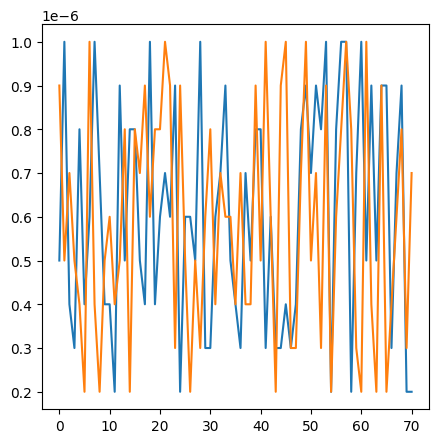

In [27]:
list_of_fet = list(list_of_fet)

fig, ax = plt.subplots(figsize=(5,5))

for _ in range(1):
    matrix = []
    
    for i in range(len(list_of_fet)):
        lst = list_of_fet.copy()
        fet = lst.pop(i)
        
        ans, loss, loss_mean = train_and_test(lst, 200, .1)
        print(i, ans, loss, loss_mean)
        
        matrix.append((ans, fet))
        
    
        
    history1.append((ans, fet))
    matrix.sort(key=lambda x: -x[0])
    matrix = matrix[:-5]
    
    list_of_fet = []
    for _, x in matrix:
        list_of_fet.append(x)
        
    ans, loss, loss_mean = train_and_test(list_of_fet)
    history.append([ans, loss, loss_mean])
        
    ax.clear()
    ax.plot(list_of_fet)
    fig.canvas.draw()

In [28]:
history

[[30.786907196044922, 3.4646265536654856e-08, 27573.298936445808],
 [34.55529022216797, 3.2722646207807014e-08, 26768.11809089432],
 [30.12510108947754, 3.563449064019196e-08, 29421.025648762494]]

In [29]:
list_of_fet

[array([5.e-07, 9.e-07]),
 array([1.e-06, 5.e-07]),
 array([4.e-07, 7.e-07]),
 array([3.e-07, 5.e-07]),
 array([8.e-07, 4.e-07]),
 array([4.e-07, 2.e-07]),
 array([6.e-07, 1.e-06]),
 array([1.e-06, 4.e-07]),
 array([7.e-07, 2.e-07]),
 array([4.e-07, 5.e-07]),
 array([4.e-07, 6.e-07]),
 array([2.e-07, 4.e-07]),
 array([9.e-07, 5.e-07]),
 array([5.e-07, 8.e-07]),
 array([8.e-07, 2.e-07]),
 array([8.e-07, 8.e-07]),
 array([5.e-07, 7.e-07]),
 array([4.e-07, 9.e-07]),
 array([1.e-06, 6.e-07]),
 array([4.e-07, 8.e-07]),
 array([6.e-07, 8.e-07]),
 array([7.e-07, 1.e-06]),
 array([6.e-07, 9.e-07]),
 array([9.e-07, 3.e-07]),
 array([2.e-07, 9.e-07]),
 array([6.e-07, 5.e-07]),
 array([6.e-07, 2.e-07]),
 array([5.e-07, 5.e-07]),
 array([1.e-06, 3.e-07]),
 array([3.e-07, 6.e-07]),
 array([3.e-07, 8.e-07]),
 array([6.e-07, 4.e-07]),
 array([7.e-07, 7.e-07]),
 array([9.e-07, 6.e-07]),
 array([5.e-07, 6.e-07]),
 array([4.e-07, 4.e-07]),
 array([3.e-07, 7.e-07]),
 array([7.e-07, 4.e-07]),
 array([5.e-

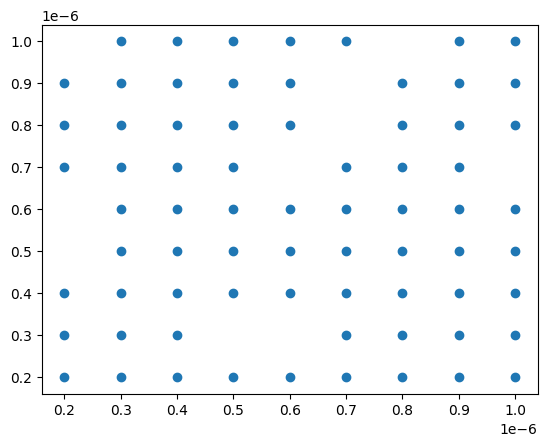

In [30]:
list_of_fet = np.array(list_of_fet)

plt.scatter(list_of_fet[:, 0], list_of_fet[:, 1])

In [31]:
train_and_test(list_of_fet)

100%|██████████████████████████████████████████████████████████████████████████████| 1491/1491 [00:48<00:00, 30.58it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 30.6966 - mse: 0.1056
Testing
17403/17403 [==============================] - 27s 2ms/step
Loss train: 30.696571350097656, MSE: 3.519449627237198e-08, MAPE: 27933.24806063747


(30.696571350097656, 3.519449627237198e-08, 27933.24806063747)

100%|██████████████████████████████████████████████████████████████████████████████| 1470/1470 [00:48<00:00, 30.50it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 31.4314 - mse: 0.1103
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 31.431413650512695, MSE: 2.8814367994397963e-08, MAPE: 21713.366919008255
0 31.431413650512695 2.8814367994397963e-08 21713.366919008255


100%|██████████████████████████████████████████████████████████████████████████████| 1470/1470 [00:48<00:00, 30.43it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 30.4574 - mse: 0.1108
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 30.45743751525879, MSE: 2.5153459962292153e-08, MAPE: 16112.667168504253
1 30.45743751525879 2.5153459962292153e-08 16112.667168504253


100%|██████████████████████████████████████████████████████████████████████████████| 1470/1470 [00:48<00:00, 30.36it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 31.6710 - mse: 0.1145
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 31.67096519470215, MSE: 2.9510218437953185e-08, MAPE: 20895.578900717217
2 31.67096519470215 2.9510218437953185e-08 20895.578900717217


100%|██████████████████████████████████████████████████████████████████████████████| 1470/1470 [00:48<00:00, 30.14it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 30.4891 - mse: 0.1089
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 30.48914909362793, MSE: 3.005534078237466e-08, MAPE: 20404.9744960233
3 30.48914909362793 3.005534078237466e-08 20404.9744960233


100%|██████████████████████████████████████████████████████████████████████████████| 1470/1470 [00:48<00:00, 30.11it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 36.9608 - mse: 0.1399
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 36.960758209228516, MSE: 2.907919345765756e-08, MAPE: 20645.392457759535
4 36.960758209228516 2.907919345765756e-08 20645.392457759535


100%|██████████████████████████████████████████████████████████████████████████████| 1470/1470 [00:48<00:00, 30.08it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 37.2156 - mse: 0.1285
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 37.2155876159668, MSE: 2.8434434494421573e-08, MAPE: 19793.81814182869
5 37.2155876159668 2.8434434494421573e-08 19793.81814182869


100%|██████████████████████████████████████████████████████████████████████████████| 1470/1470 [00:49<00:00, 29.96it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 31.8169 - mse: 0.1123
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 31.816946029663086, MSE: 2.691661072689413e-08, MAPE: 17508.39006797559
6 31.816946029663086 2.691661072689413e-08 17508.39006797559


100%|██████████████████████████████████████████████████████████████████████████████| 1470/1470 [00:49<00:00, 29.82it/s]


Learning
9/9 [==============================] - 0s 5ms/step - loss: 31.8342 - mse: 0.1144
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 31.834245681762695, MSE: 2.405010888560335e-08, MAPE: 14467.847708129015
7 31.834245681762695 2.405010888560335e-08 14467.847708129015


100%|██████████████████████████████████████████████████████████████████████████████| 1470/1470 [00:49<00:00, 29.78it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 31.9475 - mse: 0.1203
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 31.947458267211914, MSE: 2.3038699121799432e-08, MAPE: 13335.469954258038
8 31.947458267211914 2.3038699121799432e-08 13335.469954258038


100%|██████████████████████████████████████████████████████████████████████████████| 1470/1470 [00:49<00:00, 29.61it/s]


Learning
9/9 [==============================] - 0s 3ms/step - loss: 32.3938 - mse: 0.1206
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 32.393795013427734, MSE: 2.604872247518384e-08, MAPE: 14595.189057763868
9 32.393795013427734 2.604872247518384e-08 14595.189057763868


100%|██████████████████████████████████████████████████████████████████████████████| 1470/1470 [00:49<00:00, 29.60it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 30.9119 - mse: 0.1152
Testing


MemoryError: Unable to allocate 2.55 MiB for an array with shape (6, 55688) and data type float64

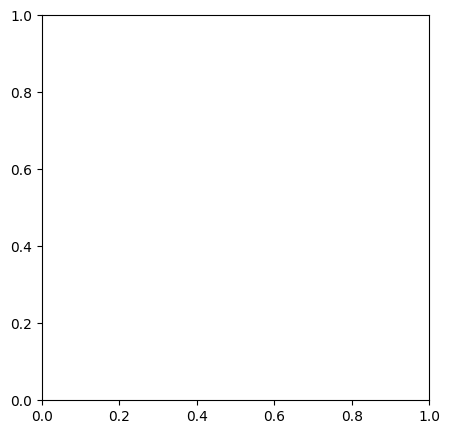

In [32]:
list_of_fet = list(list_of_fet)

fig, ax = plt.subplots(figsize=(5,5))

for _ in range(1):
    matrix = []
    
    for i in range(len(list_of_fet)):
        lst = list_of_fet.copy()
        fet = lst.pop(i)
        
        ans, loss, loss_mean = train_and_test(lst, 200, .1)
        print(i, ans, loss, loss_mean)
        
        matrix.append((ans, fet))
        
    
        
    history1.append((ans, fet))
    matrix.sort(key=lambda x: -x[0])
    matrix = matrix[:-5]
    
    list_of_fet = []
    for _, x in matrix:
        list_of_fet.append(x)
        
    ans, loss, loss_mean = train_and_test(list_of_fet)
    history.append([ans, loss, loss_mean])
        
    ax.clear()
    ax.plot(list_of_fet)
    fig.canvas.draw()

In [33]:
history

[[30.786907196044922, 3.4646265536654856e-08, 27573.298936445808],
 [34.55529022216797, 3.2722646207807014e-08, 26768.11809089432],
 [30.12510108947754, 3.563449064019196e-08, 29421.025648762494]]

In [18]:
# history = [[30.786907196044922, 3.4646265536654856e-08, 27573.298936445808],
#  [34.55529022216797, 3.2722646207807014e-08, 26768.11809089432],
#  [30.12510108947754, 3.563449064019196e-08, 29421.025648762494]]

In [34]:
list_of_fet

[array([5.e-07, 9.e-07]),
 array([1.e-06, 5.e-07]),
 array([4.e-07, 7.e-07]),
 array([3.e-07, 5.e-07]),
 array([8.e-07, 4.e-07]),
 array([4.e-07, 2.e-07]),
 array([6.e-07, 1.e-06]),
 array([1.e-06, 4.e-07]),
 array([7.e-07, 2.e-07]),
 array([4.e-07, 5.e-07]),
 array([4.e-07, 6.e-07]),
 array([2.e-07, 4.e-07]),
 array([9.e-07, 5.e-07]),
 array([5.e-07, 8.e-07]),
 array([8.e-07, 2.e-07]),
 array([8.e-07, 8.e-07]),
 array([5.e-07, 7.e-07]),
 array([4.e-07, 9.e-07]),
 array([1.e-06, 6.e-07]),
 array([4.e-07, 8.e-07]),
 array([6.e-07, 8.e-07]),
 array([7.e-07, 1.e-06]),
 array([6.e-07, 9.e-07]),
 array([9.e-07, 3.e-07]),
 array([2.e-07, 9.e-07]),
 array([6.e-07, 5.e-07]),
 array([6.e-07, 2.e-07]),
 array([5.e-07, 5.e-07]),
 array([1.e-06, 3.e-07]),
 array([3.e-07, 6.e-07]),
 array([3.e-07, 8.e-07]),
 array([6.e-07, 4.e-07]),
 array([7.e-07, 7.e-07]),
 array([9.e-07, 6.e-07]),
 array([5.e-07, 6.e-07]),
 array([4.e-07, 4.e-07]),
 array([3.e-07, 7.e-07]),
 array([7.e-07, 4.e-07]),
 array([5.e-

In [37]:
list_of_fet = [[5.e-07, 9.e-07],[1.e-06, 5.e-07],[4.e-07, 7.e-07],[3.e-07, 5.e-07],[8.e-07, 4.e-07],[4.e-07, 2.e-07],[6.e-07, 1.e-06],[1.e-06, 4.e-07],[7.e-07, 2.e-07],[4.e-07, 5.e-07],[4.e-07, 6.e-07],[2.e-07, 4.e-07],[9.e-07, 5.e-07],[5.e-07, 8.e-07],[8.e-07, 2.e-07],[8.e-07, 8.e-07],[5.e-07, 7.e-07],[4.e-07, 9.e-07],[1.e-06, 6.e-07],[4.e-07, 8.e-07],[6.e-07, 8.e-07],[7.e-07, 1.e-06],[6.e-07, 9.e-07],[9.e-07, 3.e-07],[2.e-07, 9.e-07],[6.e-07, 5.e-07],[6.e-07, 2.e-07],[5.e-07, 5.e-07],[1.e-06, 3.e-07],[3.e-07, 6.e-07],[3.e-07, 8.e-07],[6.e-07, 4.e-07],[7.e-07, 7.e-07],[9.e-07, 6.e-07],[5.e-07, 6.e-07],[4.e-07, 4.e-07],[3.e-07, 7.e-07],[7.e-07, 4.e-07],[5.e-07, 4.e-07],[8.e-07, 9.e-07],[8.e-07, 5.e-07],[3.e-07, 1.e-06],[6.e-07, 6.e-07],[3.e-07, 2.e-07],[3.e-07, 9.e-07],[4.e-07, 1.e-06],[3.e-07, 3.e-07],[4.e-07, 3.e-07],[8.e-07, 7.e-07],[9.e-07, 1.e-06],[7.e-07, 5.e-07],[9.e-07, 7.e-07],[8.e-07, 3.e-07],[1.e-06, 9.e-07],[2.e-07, 2.e-07],[8.e-07, 6.e-07],[1.e-06, 8.e-07],[1.e-06, 1.e-06],[2.e-07, 8.e-07],[7.e-07, 3.e-07],[1.e-06, 2.e-07],[5.e-07, 1.e-06],[9.e-07, 4.e-07],[5.e-07, 2.e-07],[9.e-07, 9.e-07],[9.e-07, 2.e-07],[3.e-07, 4.e-07],[7.e-07, 6.e-07],[9.e-07, 8.e-07],[2.e-07, 3.e-07],[2.e-07, 7.e-07]]

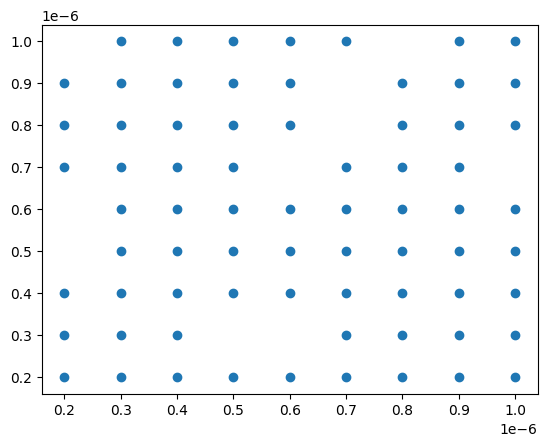

In [38]:
list_of_fet = np.array(list_of_fet)

plt.scatter(list_of_fet[:, 0], list_of_fet[:, 1])

In [36]:
train_and_test(list_of_fet)

100%|██████████████████████████████████████████████████████████████████████████████| 1491/1491 [00:53<00:00, 27.80it/s]


Learning
9/9 [==============================] - 0s 4ms/step - loss: 30.3911 - mse: 0.1060
Testing
17403/17403 [==============================] - 28s 2ms/step
Loss train: 30.3911190032959, MSE: 3.631369807427138e-08, MAPE: 28925.232531281108


(30.3911190032959, 3.631369807427138e-08, 28925.232531281108)

In [62]:
list_of_fet = [[8.e-07, 4.e-07],[4.e-07, 2.e-07],[6.e-07, 1.e-06],[1.e-06, 4.e-07],
               [7.e-07, 2.e-07],[4.e-07, 5.e-07],[4.e-07, 6.e-07],[2.e-07, 4.e-07],
               [9.e-07, 5.e-07],[5.e-07, 8.e-07],[8.e-07, 2.e-07],[8.e-07, 8.e-07],
               [5.e-07, 7.e-07],[4.e-07, 9.e-07],[1.e-06, 6.e-07],[4.e-07, 8.e-07],
               [6.e-07, 8.e-07],[7.e-07, 1.e-06],[6.e-07, 9.e-07],[9.e-07, 3.e-07],
               [2.e-07, 9.e-07],[6.e-07, 5.e-07],[6.e-07, 2.e-07],[5.e-07, 5.e-07],
               [1.e-06, 3.e-07],[3.e-07, 6.e-07],[3.e-07, 8.e-07],[6.e-07, 4.e-07],
               [7.e-07, 7.e-07],[9.e-07, 6.e-07],[5.e-07, 6.e-07],[4.e-07, 4.e-07],
               [3.e-07, 7.e-07],[7.e-07, 4.e-07],[5.e-07, 4.e-07],[8.e-07, 9.e-07],
               [8.e-07, 5.e-07],[3.e-07, 1.e-06],[6.e-07, 6.e-07],[3.e-07, 2.e-07],
               [3.e-07, 9.e-07],[4.e-07, 1.e-06],[3.e-07, 3.e-07],[4.e-07, 3.e-07],
               [8.e-07, 7.e-07],[9.e-07, 1.e-06],[7.e-07, 5.e-07],[9.e-07, 7.e-07],
               [8.e-07, 3.e-07],[1.e-06, 9.e-07],[2.e-07, 2.e-07],[8.e-07, 6.e-07],
               [1.e-06, 8.e-07],[1.e-06, 1.e-06],[2.e-07, 8.e-07],[7.e-07, 3.e-07],
               [1.e-06, 2.e-07],[5.e-07, 1.e-06],[9.e-07, 4.e-07],[5.e-07, 2.e-07],
               [9.e-07, 9.e-07],[9.e-07, 2.e-07],[3.e-07, 4.e-07],[7.e-07, 6.e-07],
               [9.e-07, 8.e-07],[2.e-07, 3.e-07],[2.e-07, 7.e-07]]

In [59]:
train_and_test(list_of_fet, 300, .1)

100%|██████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:22<00:00, 63.66it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 31.0608 - mse: 0.1078
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 31.06080436706543, MSE: 3.15746778560466e-08, MAPE: 23475.36926096944


(31.06080436706543, 3.15746778560466e-08, 23475.36926096944)

In [63]:
list_of_fet = [[7.e-07, 2.e-07],[4.e-07, 5.e-07],[4.e-07, 6.e-07],[2.e-07, 4.e-07],
               [9.e-07, 5.e-07],[5.e-07, 8.e-07],[8.e-07, 2.e-07],[8.e-07, 8.e-07],
               [5.e-07, 7.e-07],[4.e-07, 9.e-07],[1.e-06, 6.e-07],[4.e-07, 8.e-07],
               [6.e-07, 8.e-07],[7.e-07, 1.e-06],[6.e-07, 9.e-07],[9.e-07, 3.e-07],
               [2.e-07, 9.e-07],[6.e-07, 5.e-07],[6.e-07, 2.e-07],[5.e-07, 5.e-07],
               [1.e-06, 3.e-07],[3.e-07, 6.e-07],[3.e-07, 8.e-07],[6.e-07, 4.e-07],
               [7.e-07, 7.e-07],[9.e-07, 6.e-07],[5.e-07, 6.e-07],[4.e-07, 4.e-07],
               [3.e-07, 7.e-07],[7.e-07, 4.e-07],[5.e-07, 4.e-07],[8.e-07, 9.e-07],
               [8.e-07, 5.e-07],[3.e-07, 1.e-06],[6.e-07, 6.e-07],[3.e-07, 2.e-07],
               [3.e-07, 9.e-07],[4.e-07, 1.e-06],[3.e-07, 3.e-07],[4.e-07, 3.e-07],
               [8.e-07, 7.e-07],[9.e-07, 1.e-06],[7.e-07, 5.e-07],[9.e-07, 7.e-07],
               [8.e-07, 3.e-07],[1.e-06, 9.e-07],[2.e-07, 2.e-07],[8.e-07, 6.e-07],
               [1.e-06, 8.e-07],[1.e-06, 1.e-06],[2.e-07, 8.e-07],[7.e-07, 3.e-07],
               [1.e-06, 2.e-07],[5.e-07, 1.e-06],[9.e-07, 4.e-07],[5.e-07, 2.e-07],
               [9.e-07, 9.e-07],[9.e-07, 2.e-07],[3.e-07, 4.e-07],[7.e-07, 6.e-07],
               [9.e-07, 8.e-07],[2.e-07, 3.e-07],[2.e-07, 7.e-07]]

In [61]:
train_and_test(list_of_fet, 300, .1)

100%|██████████████████████████████████████████████████████████████████████████████| 1323/1323 [00:20<00:00, 64.03it/s]


Learning
8/8 [==============================] - 0s 3ms/step - loss: 33.1454 - mse: 0.1132
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 33.145408630371094, MSE: 2.859853465501378e-08, MAPE: 22153.937579424168


(33.145408630371094, 2.859853465501378e-08, 22153.937579424168)

In [65]:
len(list_of_fet)

63

100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:23<00:00, 54.59it/s]


Learning
8/8 [==============================] - 0s 3ms/step - loss: 29.4779 - mse: 0.1145
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 29.477933883666992, MSE: 2.858412759767229e-08, MAPE: 22020.36644204219
0 29.477933883666992 2.858412759767229e-08 22020.36644204219


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:37<00:00, 34.32it/s]


Learning
8/8 [==============================] - 0s 5ms/step - loss: 30.0766 - mse: 0.1200
Testing
1741/1741 [==============================] - 5s 3ms/step
Loss train: 30.076602935791016, MSE: 2.6906889594122192e-08, MAPE: 18143.442017334408
1 30.076602935791016 2.6906889594122192e-08 18143.442017334408


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:23<00:00, 54.37it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 30.5864 - mse: 0.1190
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 30.586366653442383, MSE: 2.7195418458308574e-08, MAPE: 18162.48445314965
2 30.586366653442383 2.7195418458308574e-08 18162.48445314965


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:24<00:00, 54.04it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 32.6489 - mse: 0.1328
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 32.648860931396484, MSE: 2.8494815771440132e-08, MAPE: 16291.577033043215
3 32.648860931396484 2.8494815771440132e-08 16291.577033043215


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:24<00:00, 53.58it/s]


Learning
8/8 [==============================] - 0s 3ms/step - loss: 30.5976 - mse: 0.1206
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 30.59763526916504, MSE: 3.1684652026009997e-08, MAPE: 23095.03619963527
4 30.59763526916504 3.1684652026009997e-08 23095.03619963527


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:22<00:00, 58.66it/s]


Learning
8/8 [==============================] - 0s 3ms/step - loss: 30.5558 - mse: 0.1185
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 30.555774688720703, MSE: 2.5997675375393542e-08, MAPE: 17462.465131839803
5 30.555774688720703 2.5997675375393542e-08 17462.465131839803


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:23<00:00, 56.26it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 30.7248 - mse: 0.1177
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 30.724794387817383, MSE: 2.7502271968617645e-08, MAPE: 19740.724282792427
6 30.724794387817383 2.7502271968617645e-08 19740.724282792427


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:25<00:00, 51.97it/s]


Learning
8/8 [==============================] - 0s 3ms/step - loss: 31.8615 - mse: 0.1230
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 31.861461639404297, MSE: 2.7660139002005968e-08, MAPE: 19446.87324898297
7 31.861461639404297 2.7660139002005968e-08 19446.87324898297


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:24<00:00, 53.07it/s]


Learning
8/8 [==============================] - 0s 3ms/step - loss: 30.2206 - mse: 0.1162
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 30.220645904541016, MSE: 2.773423100014237e-08, MAPE: 20478.906491671998
8 30.220645904541016 2.773423100014237e-08 20478.906491671998


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:24<00:00, 52.25it/s]


Learning
8/8 [==============================] - 0s 3ms/step - loss: 29.9277 - mse: 0.1190
Testing
1741/1741 [==============================] - 2s 1ms/step
Loss train: 29.92766761779785, MSE: 2.7576334518695937e-08, MAPE: 16657.745052741757
9 29.92766761779785 2.7576334518695937e-08 16657.745052741757


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:25<00:00, 50.44it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 30.1580 - mse: 0.1188
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 30.157983779907227, MSE: 2.7108442734353033e-08, MAPE: 20125.34182410335
10 30.157983779907227 2.7108442734353033e-08 20125.34182410335


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:46<00:00, 28.27it/s]


Learning
8/8 [==============================] - 0s 7ms/step - loss: 61.6190 - mse: 0.3521
Testing
1741/1741 [==============================] - 7s 4ms/step
Loss train: 61.61895751953125, MSE: 3.338663436381904e-08, MAPE: 25405.55980666461
11 61.61895751953125 3.338663436381904e-08 25405.55980666461


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:52<00:00, 24.60it/s]


Learning
8/8 [==============================] - 0s 5ms/step - loss: 30.2081 - mse: 0.1187
Testing
1741/1741 [==============================] - 5s 3ms/step
Loss train: 30.208126068115234, MSE: 2.650490102304283e-08, MAPE: 18805.690235071914
12 30.208126068115234 2.650490102304283e-08 18805.690235071914


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:48<00:00, 27.04it/s]


Learning
8/8 [==============================] - 0s 5ms/step - loss: 31.8356 - mse: 0.1225
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 31.83559226989746, MSE: 2.8252146040328748e-08, MAPE: 21159.116249597915
13 31.83559226989746 2.8252146040328748e-08 21159.116249597915


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:41<00:00, 31.63it/s]


Learning
8/8 [==============================] - 0s 6ms/step - loss: 30.5183 - mse: 0.1182
Testing
1741/1741 [==============================] - 5s 3ms/step
Loss train: 30.518325805664062, MSE: 2.753678547221323e-08, MAPE: 19583.53351249189
14 30.518325805664062 2.753678547221323e-08 19583.53351249189


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:41<00:00, 31.65it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 29.7113 - mse: 0.1155
Testing
1741/1741 [==============================] - 7s 4ms/step
Loss train: 29.711286544799805, MSE: 2.7200117099699285e-08, MAPE: 19407.183020395685
15 29.711286544799805 2.7200117099699285e-08 19407.183020395685


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:42<00:00, 30.46it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 27.2505 - mse: 0.1100
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 27.25048065185547, MSE: 3.19348558491156e-08, MAPE: 24189.944170787337
16 27.25048065185547 3.19348558491156e-08 24189.944170787337


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:37<00:00, 34.28it/s]


Learning
8/8 [==============================] - 0s 5ms/step - loss: 34.4357 - mse: 0.1202
Testing
1741/1741 [==============================] - 5s 3ms/step
Loss train: 34.43574142456055, MSE: 2.6645350888060646e-08, MAPE: 18374.22477295545
17 34.43574142456055 2.6645350888060646e-08 18374.22477295545


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:43<00:00, 30.26it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 35.4189 - mse: 0.1136
Testing
1741/1741 [==============================] - 5s 3ms/step
Loss train: 35.41889953613281, MSE: 2.971054162602613e-08, MAPE: 22721.26710033031
18 35.41889953613281 2.971054162602613e-08 22721.26710033031


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:55<00:00, 23.67it/s]


Learning
8/8 [==============================] - 0s 5ms/step - loss: 35.6858 - mse: 0.1172
Testing
1741/1741 [==============================] - 5s 3ms/step
Loss train: 35.68581008911133, MSE: 2.869385737425242e-08, MAPE: 21447.932415932723
19 35.68581008911133 2.869385737425242e-08 21447.932415932723


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:43<00:00, 29.68it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 33.3674 - mse: 0.1151
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 33.36741256713867, MSE: 2.920443550187092e-08, MAPE: 22724.711480347276
20 33.36741256713867 2.920443550187092e-08 22724.711480347276


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:41<00:00, 31.43it/s]


Learning
8/8 [==============================] - 0s 3ms/step - loss: 44.8373 - mse: 0.1197
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 44.8372688293457, MSE: 3.2553533951067395e-08, MAPE: 26548.58938300866
21 44.8372688293457 3.2553533951067395e-08 26548.58938300866


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:45<00:00, 28.47it/s]


Learning
8/8 [==============================] - 0s 3ms/step - loss: 37.1066 - mse: 0.1139
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 37.10662841796875, MSE: 3.1073087867545896e-08, MAPE: 24128.78908541745
22 37.10662841796875 3.1073087867545896e-08 24128.78908541745


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:37<00:00, 34.95it/s]


Learning
8/8 [==============================] - 0s 5ms/step - loss: 39.9621 - mse: 0.1356
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 39.96205139160156, MSE: 2.3271735100998574e-08, MAPE: 11502.941638284774
23 39.96205139160156 2.3271735100998574e-08 11502.941638284774


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:36<00:00, 35.89it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 35.5064 - mse: 0.1166
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 35.50637435913086, MSE: 2.7708651185141075e-08, MAPE: 18726.052599326307
24 35.50637435913086 2.7708651185141075e-08 18726.052599326307


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:38<00:00, 33.47it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 34.4256 - mse: 0.1213
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 34.425594329833984, MSE: 2.48688212339395e-08, MAPE: 15293.91293573674
25 34.425594329833984 2.48688212339395e-08 15293.91293573674


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:34<00:00, 37.63it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 34.5575 - mse: 0.1180
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 34.55748748779297, MSE: 3.0600590809944814e-08, MAPE: 24224.593201724067
26 34.55748748779297 3.0600590809944814e-08 24224.593201724067


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:39<00:00, 32.69it/s]


Learning
8/8 [==============================] - 0s 5ms/step - loss: 36.3213 - mse: 0.1150
Testing
1741/1741 [==============================] - 4s 3ms/step
Loss train: 36.3212776184082, MSE: 2.773924570412288e-08, MAPE: 20372.02722028271
27 36.3212776184082 2.773924570412288e-08 20372.02722028271


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:40<00:00, 31.83it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 38.5998 - mse: 0.1147
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 38.59978103637695, MSE: 3.3031616688893204e-08, MAPE: 26060.11338176235
28 38.59978103637695 3.3031616688893204e-08 26060.11338176235


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:40<00:00, 31.98it/s]


Learning
8/8 [==============================] - 0s 5ms/step - loss: 37.8786 - mse: 0.1185
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 37.87864303588867, MSE: 3.093290626142658e-08, MAPE: 22704.611313343237
29 37.87864303588867 3.093290626142658e-08 22704.611313343237


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:40<00:00, 31.90it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 33.0232 - mse: 0.1203
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 33.0231819152832, MSE: 2.9048640836046886e-08, MAPE: 20174.524162269696
30 33.0231819152832 2.9048640836046886e-08 20174.524162269696


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:42<00:00, 30.56it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 37.2968 - mse: 0.1145
Testing
1741/1741 [==============================] - 5s 3ms/step
Loss train: 37.29680633544922, MSE: 2.7752279895535932e-08, MAPE: 21854.820857714305
31 37.29680633544922 2.7752279895535932e-08 21854.820857714305


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:37<00:00, 34.78it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 35.5227 - mse: 0.1187
Testing
1741/1741 [==============================] - 5s 3ms/step
Loss train: 35.52268600463867, MSE: 2.5762438290366795e-08, MAPE: 17343.46949193436
32 35.52268600463867 2.5762438290366795e-08 17343.46949193436


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:42<00:00, 30.30it/s]


Learning
8/8 [==============================] - 0s 3ms/step - loss: 33.3970 - mse: 0.1133
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 33.396976470947266, MSE: 3.0599450335481096e-08, MAPE: 23404.229020958668
33 33.396976470947266 3.0599450335481096e-08 23404.229020958668


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:38<00:00, 33.93it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 34.2349 - mse: 0.1138
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 34.23491287231445, MSE: 2.9355846081643864e-08, MAPE: 22309.6619099311
34 34.23491287231445 2.9355846081643864e-08 22309.6619099311


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:42<00:00, 30.41it/s]


Learning
8/8 [==============================] - 0s 3ms/step - loss: 33.4912 - mse: 0.1189
Testing
1741/1741 [==============================] - 4s 3ms/step
Loss train: 33.491241455078125, MSE: 2.7972902249137947e-08, MAPE: 19615.474388757204
35 33.491241455078125 2.7972902249137947e-08 19615.474388757204


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:43<00:00, 29.69it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 37.4210 - mse: 0.1126
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 37.42103576660156, MSE: 3.0865463266692225e-08, MAPE: 24577.944311871626
36 37.42103576660156 3.0865463266692225e-08 24577.944311871626


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:43<00:00, 29.64it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 36.5625 - mse: 0.1148
Testing
1741/1741 [==============================] - 5s 3ms/step
Loss train: 36.562503814697266, MSE: 3.3181078561079875e-08, MAPE: 26860.123376939137
37 36.562503814697266 3.3181078561079875e-08 26860.123376939137


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:48<00:00, 27.09it/s]


Learning
8/8 [==============================] - 0s 5ms/step - loss: 33.1065 - mse: 0.1154
Testing
1741/1741 [==============================] - 5s 3ms/step
Loss train: 33.10649871826172, MSE: 3.004053010762302e-08, MAPE: 22094.083869879243
38 33.10649871826172 3.004053010762302e-08 22094.083869879243


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:44<00:00, 29.50it/s]


Learning
8/8 [==============================] - 0s 5ms/step - loss: 32.9312 - mse: 0.1188
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 32.93121337890625, MSE: 2.6500988128409718e-08, MAPE: 18537.16963800702
39 32.93121337890625 2.6500988128409718e-08 18537.16963800702


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:38<00:00, 34.24it/s]


Learning
8/8 [==============================] - 0s 3ms/step - loss: 34.4644 - mse: 0.1192
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 34.46435546875, MSE: 2.5574111214108022e-08, MAPE: 16502.764287189337
40 34.46435546875 2.5574111214108022e-08 16502.764287189337


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:38<00:00, 33.71it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 33.8333 - mse: 0.1151
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 33.83333206176758, MSE: 3.185599593191732e-08, MAPE: 23650.58496498457
41 33.83333206176758 3.185599593191732e-08 23650.58496498457


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:38<00:00, 33.65it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 32.7692 - mse: 0.1298
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 32.7691764831543, MSE: 2.5226957935452223e-08, MAPE: 14957.057134182463
42 32.7691764831543 2.5226957935452223e-08 14957.057134182463


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:40<00:00, 32.11it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 35.7737 - mse: 0.1315
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 35.773738861083984, MSE: 2.3691643346872433e-08, MAPE: 15649.504924962675
43 35.773738861083984 2.3691643346872433e-08 15649.504924962675


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:40<00:00, 32.10it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 36.0293 - mse: 0.1142
Testing
1741/1741 [==============================] - 5s 3ms/step
Loss train: 36.029319763183594, MSE: 2.9975015879559115e-08, MAPE: 24408.506548240384
44 36.029319763183594 2.9975015879559115e-08 24408.506548240384


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:45<00:00, 28.86it/s]


Learning
8/8 [==============================] - 0s 5ms/step - loss: 33.8747 - mse: 0.1170
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 33.87474060058594, MSE: 2.9431477289170276e-08, MAPE: 19261.905215290302
45 33.87474060058594 2.9431477289170276e-08 19261.905215290302


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:41<00:00, 31.21it/s]


Learning
8/8 [==============================] - 0s 5ms/step - loss: 36.5952 - mse: 0.1163
Testing
1741/1741 [==============================] - 4s 3ms/step
Loss train: 36.595218658447266, MSE: 3.227835891997825e-08, MAPE: 23564.967715999304
46 36.595218658447266 3.227835891997825e-08 23564.967715999304


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:44<00:00, 29.25it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 39.0146 - mse: 0.1400
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 39.01464080810547, MSE: 2.2985297342598198e-08, MAPE: 12044.583592289548
47 39.01464080810547 2.2985297342598198e-08 12044.583592289548


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:42<00:00, 30.77it/s]


Learning
8/8 [==============================] - 0s 5ms/step - loss: 38.8416 - mse: 0.1253
Testing
1741/1741 [==============================] - 5s 3ms/step
Loss train: 38.84162902832031, MSE: 2.6324970219410438e-08, MAPE: 16394.457418426868
48 38.84162902832031 2.6324970219410438e-08 16394.457418426868


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:44<00:00, 29.49it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 34.1321 - mse: 0.1164
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 34.13206481933594, MSE: 2.9517298210906245e-08, MAPE: 21723.220551326755
49 34.13206481933594 2.9517298210906245e-08 21723.220551326755


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:46<00:00, 28.12it/s]


Learning
8/8 [==============================] - 0s 7ms/step - loss: 34.9732 - mse: 0.1111
Testing
1741/1741 [==============================] - 5s 3ms/step
Loss train: 34.97315216064453, MSE: 3.22039941344279e-08, MAPE: 25816.858286088525
50 34.97315216064453 3.22039941344279e-08 25816.858286088525


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:57<00:00, 22.48it/s]


Learning
8/8 [==============================] - 0s 5ms/step - loss: 37.4870 - mse: 0.1144
Testing
1741/1741 [==============================] - 5s 3ms/step
Loss train: 37.487003326416016, MSE: 2.850807623716581e-08, MAPE: 22024.621065872303
51 37.487003326416016 2.850807623716581e-08 22024.621065872303


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:44<00:00, 29.24it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 37.1822 - mse: 0.1653
Testing
1741/1741 [==============================] - 5s 3ms/step
Loss train: 37.182193756103516, MSE: 2.027618459215439e-08, MAPE: 5166.268387402043
52 37.182193756103516 2.027618459215439e-08 5166.268387402043


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:43<00:00, 29.63it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 202.4082 - mse: 0.1119
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 202.40823364257812, MSE: 3.183914363843923e-08, MAPE: 25698.288363306045
53 202.40823364257812 3.183914363843923e-08 25698.288363306045


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:43<00:00, 29.72it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 39.4117 - mse: 0.1141
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 39.411746978759766, MSE: 3.2971720344626395e-08, MAPE: 25180.462011419782
54 39.411746978759766 3.2971720344626395e-08 25180.462011419782


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:45<00:00, 28.69it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 33.8412 - mse: 0.1151
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 33.84117889404297, MSE: 2.8761004138693406e-08, MAPE: 21852.590479205748
55 33.84117889404297 2.8761004138693406e-08 21852.590479205748


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:39<00:00, 33.23it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 33.1017 - mse: 0.1198
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 33.1016960144043, MSE: 2.91997704482603e-08, MAPE: 22964.330108564616
56 33.1016960144043 2.91997704482603e-08 22964.330108564616


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:45<00:00, 28.74it/s]


Learning
8/8 [==============================] - 0s 3ms/step - loss: 33.1381 - mse: 0.1238
Testing
1741/1741 [==============================] - 3s 2ms/step
Loss train: 33.13812255859375, MSE: 2.5298249176105743e-08, MAPE: 16724.876561377532
57 33.13812255859375 2.5298249176105743e-08 16724.876561377532


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:33<00:00, 39.09it/s]


Learning
8/8 [==============================] - 0s 3ms/step - loss: 35.5549 - mse: 0.1145
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 35.554927825927734, MSE: 2.989045502634993e-08, MAPE: 23993.953384938173
58 35.554927825927734 2.989045502634993e-08 23993.953384938173


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:42<00:00, 30.59it/s]


Learning
8/8 [==============================] - 0s 5ms/step - loss: 33.4274 - mse: 0.1188
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 33.42741775512695, MSE: 2.9587885523750822e-08, MAPE: 20037.538460476015
59 33.42741775512695 2.9587885523750822e-08 20037.538460476015


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:47<00:00, 27.60it/s]


Learning
8/8 [==============================] - 0s 5ms/step - loss: 35.2793 - mse: 0.1144
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 35.27933120727539, MSE: 2.8021698689212055e-08, MAPE: 20497.22244568558
60 35.27933120727539 2.8021698689212055e-08 20497.22244568558


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:46<00:00, 28.08it/s]


Learning
8/8 [==============================] - 0s 5ms/step - loss: 37.1715 - mse: 0.1181
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 37.171451568603516, MSE: 3.103681924218945e-08, MAPE: 24534.100923326343
61 37.171451568603516 3.103681924218945e-08 24534.100923326343


100%|██████████████████████████████████████████████████████████████████████████████| 1302/1302 [00:46<00:00, 27.95it/s]


Learning
8/8 [==============================] - 0s 4ms/step - loss: 34.3782 - mse: 0.1137
Testing
1741/1741 [==============================] - 4s 2ms/step
Loss train: 34.3781852722168, MSE: 3.32983080453317e-08, MAPE: 25455.269155253685
62 34.3781852722168 3.32983080453317e-08 25455.269155253685
[(202.40823364257812, [5e-07, 1e-06]), (61.61895751953125, [4e-07, 8e-07]), (44.8372688293457, [3e-07, 6e-07]), (39.96205139160156, [6e-07, 4e-07]), (39.411746978759766, [9e-07, 4e-07]), (39.01464080810547, [8e-07, 6e-07]), (38.84162902832031, [1e-06, 8e-07]), (38.59978103637695, [3e-07, 7e-07]), (37.87864303588867, [7e-07, 4e-07]), (37.487003326416016, [7e-07, 3e-07]), (37.42103576660156, [3e-07, 9e-07]), (37.29680633544922, [8e-07, 9e-07]), (37.182193756103516, [1e-06, 2e-07]), (37.171451568603516, [2e-07, 3e-07]), (37.10662841796875, [3e-07, 8e-07]), (36.595218658447266, [2e-07, 2e-07]), (36.562503814697266, [4e-07, 1e-06]), (36.3212776184082, [4e-07, 4e-07]), (36.029319763183594, [8e-07, 3e

100%|██████████████████████████████████████████████████████████████████████████████| 1218/1218 [00:42<00:00, 28.42it/s]


Learning
7/7 [==============================] - 0s 3ms/step - loss: 32.4830 - mse: 0.0987
Testing
17403/17403 [==============================] - 40s 2ms/step
Loss train: 32.48299789428711, MSE: 3.548104555917323e-08, MAPE: 29659.738604450144


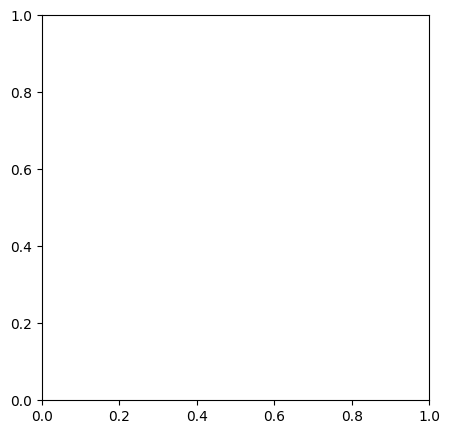

In [67]:
list_of_fet = list(list_of_fet)

fig, ax = plt.subplots(figsize=(5,5))

for _ in range(1):
    matrix = []
    
    for i in range(len(list_of_fet)):
        lst = list_of_fet.copy()
        fet = lst.pop(i)
        
        ans, loss, loss_mean = train_and_test(lst, 300, .1)
        print(i, ans, loss, loss_mean)
        
        matrix.append((ans, fet))
        
    
        
    history1.append((ans, fet))
    matrix.sort(key=lambda x: -x[0])
    print(matrix)
    matrix = matrix[:-5]
    
    list_of_fet = []
    for _, x in matrix:
        list_of_fet.append(x)
        
    ans, loss, loss_mean = train_and_test(list_of_fet)
    history.append([ans, loss, loss_mean])
        
#     ax.clear()
#     ax.plot(list_of_fet)
#     fig.canvas.draw()

In [68]:
history

[[30.786907196044922, 3.4646265536654856e-08, 27573.298936445808],
 [34.55529022216797, 3.2722646207807014e-08, 26768.11809089432],
 [30.12510108947754, 3.563449064019196e-08, 29421.025648762494],
 [32.48299789428711, 3.548104555917323e-08, 29659.738604450144]]

In [73]:
list_of_fet

[[5e-07, 1e-06],
 [4e-07, 8e-07],
 [3e-07, 6e-07],
 [6e-07, 4e-07],
 [9e-07, 4e-07],
 [8e-07, 6e-07],
 [1e-06, 8e-07],
 [3e-07, 7e-07],
 [7e-07, 4e-07],
 [7e-07, 3e-07],
 [3e-07, 9e-07],
 [8e-07, 9e-07],
 [1e-06, 2e-07],
 [2e-07, 3e-07],
 [3e-07, 8e-07],
 [2e-07, 2e-07],
 [4e-07, 1e-06],
 [4e-07, 4e-07],
 [8e-07, 3e-07],
 [9e-07, 7e-07],
 [5e-07, 5e-07],
 [3e-07, 4e-07],
 [8e-07, 5e-07],
 [7e-07, 7e-07],
 [6e-07, 2e-07],
 [9e-07, 8e-07],
 [2e-07, 8e-07],
 [5e-07, 6e-07],
 [8e-07, 7e-07],
 [6e-07, 5e-07],
 [9e-07, 6e-07],
 [2e-07, 7e-07],
 [6e-07, 6e-07],
 [1e-06, 1e-06],
 [1e-06, 9e-07],
 [5e-07, 2e-07],
 [9e-07, 1e-06],
 [3e-07, 2e-07],
 [7e-07, 6e-07],
 [3e-07, 1e-06],
 [1e-06, 3e-07],
 [9e-07, 2e-07],
 [3e-07, 3e-07],
 [9e-07, 9e-07],
 [5e-07, 4e-07],
 [4e-07, 3e-07],
 [7e-07, 5e-07],
 [2e-07, 4e-07],
 [8e-07, 8e-07],
 [7e-07, 1e-06],
 [8e-07, 2e-07],
 [9e-07, 5e-07],
 [4e-07, 6e-07],
 [5e-07, 8e-07],
 [6e-07, 9e-07],
 [5e-07, 7e-07],
 [6e-07, 8e-07],
 [1e-06, 6e-07]]

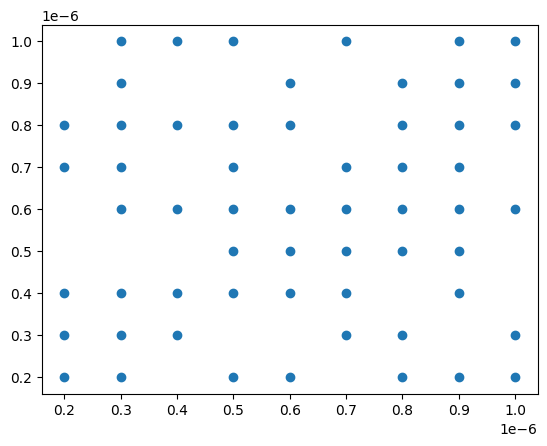

In [74]:
list_of_fet = np.array(list_of_fet)

plt.scatter(list_of_fet[:, 0], list_of_fet[:, 1])

In [75]:
train_and_test(list_of_fet)

100%|██████████████████████████████████████████████████████████████████████████████| 1218/1218 [00:39<00:00, 30.86it/s]


Learning
7/7 [==============================] - 0s 4ms/step - loss: 33.8338 - mse: 0.0984
Testing
17403/17403 [==============================] - 38s 2ms/step
Loss train: 33.83380126953125, MSE: 3.5873978136614834e-08, MAPE: 29661.626579621174


(33.83380126953125, 3.5873978136614834e-08, 29661.626579621174)

In [77]:
matrix.sort(key=lambda x: -x[0])
print(matrix)
matrix = matrix[:-10]
    
list_of_fet = []
for _, x in matrix:
    list_of_fet.append(x)

[(202.40823364257812, [5e-07, 1e-06]), (61.61895751953125, [4e-07, 8e-07]), (44.8372688293457, [3e-07, 6e-07]), (39.96205139160156, [6e-07, 4e-07]), (39.411746978759766, [9e-07, 4e-07]), (39.01464080810547, [8e-07, 6e-07]), (38.84162902832031, [1e-06, 8e-07]), (38.59978103637695, [3e-07, 7e-07]), (37.87864303588867, [7e-07, 4e-07]), (37.487003326416016, [7e-07, 3e-07]), (37.42103576660156, [3e-07, 9e-07]), (37.29680633544922, [8e-07, 9e-07]), (37.182193756103516, [1e-06, 2e-07]), (37.171451568603516, [2e-07, 3e-07]), (37.10662841796875, [3e-07, 8e-07]), (36.595218658447266, [2e-07, 2e-07]), (36.562503814697266, [4e-07, 1e-06]), (36.3212776184082, [4e-07, 4e-07]), (36.029319763183594, [8e-07, 3e-07]), (35.773738861083984, [9e-07, 7e-07]), (35.68581008911133, [5e-07, 5e-07]), (35.554927825927734, [3e-07, 4e-07]), (35.52268600463867, [8e-07, 5e-07]), (35.50637435913086, [7e-07, 7e-07]), (35.41889953613281, [6e-07, 2e-07]), (35.27933120727539, [9e-07, 8e-07]), (34.97315216064453, [2e-07, 8

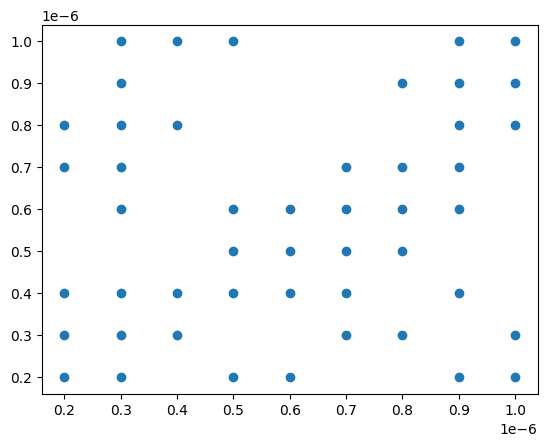

In [79]:
list_of_fet = np.array(list_of_fet)

plt.scatter(list_of_fet[:, 0], list_of_fet[:, 1])

In [78]:
train_and_test(list_of_fet)

100%|██████████████████████████████████████████████████████████████████████████████| 1008/1008 [00:36<00:00, 27.95it/s]


Learning
6/6 [==============================] - 0s 4ms/step - loss: 31.9872 - mse: 0.1025
Testing
17403/17403 [==============================] - 41s 2ms/step
Loss train: 31.987224578857422, MSE: 3.5064010453582105e-08, MAPE: 27032.779173611725


(31.987224578857422, 3.5064010453582105e-08, 27032.779173611725)

In [80]:
len(list_of_fet)

48

100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:30<00:00, 32.53it/s]


Learning
6/6 [==============================] - 0s 4ms/step - loss: 30.1176 - mse: 0.1129
Testing
3481/3481 [==============================] - 7s 2ms/step
Loss train: 30.117643356323242, MSE: 3.456034359691236e-08, MAPE: 25672.316767408753
0 30.117643356323242 3.456034359691236e-08 25672.316767408753


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:29<00:00, 33.40it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 29.6100 - mse: 0.1115
Testing
3481/3481 [==============================] - 7s 2ms/step
Loss train: 29.609996795654297, MSE: 3.354193880235952e-08, MAPE: 26265.32143535043
1 29.609996795654297 3.354193880235952e-08 26265.32143535043


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:32<00:00, 30.60it/s]


Learning
6/6 [==============================] - 0s 4ms/step - loss: 30.1172 - mse: 0.1136
Testing
3481/3481 [==============================] - 7s 2ms/step
Loss train: 30.117246627807617, MSE: 3.0460508471978616e-08, MAPE: 24204.93653826182
2 30.117246627807617 3.0460508471978616e-08 24204.93653826182


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:32<00:00, 30.37it/s]


Learning
6/6 [==============================] - 0s 4ms/step - loss: 29.6792 - mse: 0.1139
Testing
3481/3481 [==============================] - 7s 2ms/step
Loss train: 29.679187774658203, MSE: 2.7722006267540187e-08, MAPE: 19783.110809584396
3 29.679187774658203 2.7722006267540187e-08 19783.110809584396


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:30<00:00, 32.78it/s]


Learning
6/6 [==============================] - 0s 4ms/step - loss: 28.7458 - mse: 0.1133
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 28.745805740356445, MSE: 3.1182203195892095e-08, MAPE: 24368.9279376761
4 28.745805740356445 3.1182203195892095e-08 24368.9279376761


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:31<00:00, 31.73it/s]


Learning
6/6 [==============================] - 0s 3ms/step - loss: 28.9393 - mse: 0.1125
Testing
3481/3481 [==============================] - 9s 3ms/step
Loss train: 28.939266204833984, MSE: 3.210806983119213e-08, MAPE: 25191.639965357783
5 28.939266204833984 3.210806983119213e-08 25191.639965357783


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:41<00:00, 23.91it/s]


Learning
6/6 [==============================] - 0s 6ms/step - loss: 29.2725 - mse: 0.1120
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 29.272476196289062, MSE: 3.2528890975397685e-08, MAPE: 25038.155834327197
6 29.272476196289062 3.2528890975397685e-08 25038.155834327197


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:35<00:00, 27.94it/s]


Learning
6/6 [==============================] - 0s 14ms/step - loss: 29.5824 - mse: 0.1137
Testing
3481/3481 [==============================] - 10s 3ms/step
Loss train: 29.582372665405273, MSE: 3.257377087400696e-08, MAPE: 26110.371959202097
7 29.582372665405273 3.257377087400696e-08 26110.371959202097


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:31<00:00, 31.13it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 36.9856 - mse: 0.1530
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 36.98563766479492, MSE: 2.3244932814890756e-08, MAPE: 13189.719501552532
8 36.98563766479492 2.3244932814890756e-08 13189.719501552532


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:42<00:00, 23.40it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 29.0110 - mse: 0.1131
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 29.01095199584961, MSE: 3.082725834821793e-08, MAPE: 24746.669218714524
9 29.01095199584961 3.082725834821793e-08 24746.669218714524


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:32<00:00, 30.77it/s]


Learning
6/6 [==============================] - 0s 6ms/step - loss: 32.8492 - mse: 0.1103
Testing
3481/3481 [==============================] - 11s 3ms/step
Loss train: 32.84920120239258, MSE: 3.3079325567526424e-08, MAPE: 25545.681562949405
10 32.84920120239258 3.3079325567526424e-08 25545.681562949405


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:44<00:00, 22.09it/s]


Learning
6/6 [==============================] - 0s 4ms/step - loss: 29.7206 - mse: 0.1147
Testing
3481/3481 [==============================] - 7s 2ms/step
Loss train: 29.720626831054688, MSE: 3.14492381124608e-08, MAPE: 26228.44039439204
11 29.720626831054688 3.14492381124608e-08 26228.44039439204


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:36<00:00, 26.80it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 28.4653 - mse: 0.1107
Testing
3481/3481 [==============================] - 9s 2ms/step
Loss train: 28.46527671813965, MSE: 3.3766656121872824e-08, MAPE: 27856.101836586808
12 28.46527671813965 3.3766656121872824e-08 27856.101836586808


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:43<00:00, 22.61it/s]


Learning
6/6 [==============================] - 0s 6ms/step - loss: 30.4311 - mse: 0.1117
Testing
3481/3481 [==============================] - 9s 2ms/step
Loss train: 30.43107032775879, MSE: 3.106608494234516e-08, MAPE: 25368.635225904407
13 30.43107032775879 3.106608494234516e-08 25368.635225904407


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:37<00:00, 26.35it/s]


Learning
6/6 [==============================] - 0s 3ms/step - loss: 30.6949 - mse: 0.1116
Testing
3481/3481 [==============================] - 7s 2ms/step
Loss train: 30.69493865966797, MSE: 3.419593736201675e-08, MAPE: 26936.173242913646
14 30.69493865966797 3.419593736201675e-08 26936.173242913646


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:39<00:00, 25.10it/s]


Learning
6/6 [==============================] - 0s 4ms/step - loss: 30.0360 - mse: 0.1121
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 30.035993576049805, MSE: 3.149784677702045e-08, MAPE: 23814.099309697787
15 30.035993576049805 3.149784677702045e-08 23814.099309697787


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:33<00:00, 29.65it/s]


Learning
6/6 [==============================] - 0s 4ms/step - loss: 31.3701 - mse: 0.1161
Testing
3481/3481 [==============================] - 7s 2ms/step
Loss train: 31.370073318481445, MSE: 3.345848915311585e-08, MAPE: 26775.87854130379
16 31.370073318481445 3.345848915311585e-08 26775.87854130379


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:30<00:00, 32.77it/s]


Learning
6/6 [==============================] - 0s 6ms/step - loss: 30.2881 - mse: 0.1120
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 30.288118362426758, MSE: 2.9651491873391355e-08, MAPE: 24506.072105961153
17 30.288118362426758 2.9651491873391355e-08 24506.072105961153


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:38<00:00, 25.39it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 29.1622 - mse: 0.1106
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 29.162193298339844, MSE: 3.176474744277763e-08, MAPE: 25840.62017367785
18 29.162193298339844 3.176474744277763e-08 25840.62017367785


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:39<00:00, 25.01it/s]


Learning
6/6 [==============================] - 0s 6ms/step - loss: 29.7493 - mse: 0.1127
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 29.749296188354492, MSE: 3.106218131470221e-08, MAPE: 23648.898119542377
19 29.749296188354492 3.106218131470221e-08 23648.898119542377


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:39<00:00, 24.98it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 30.1700 - mse: 0.1122
Testing
3481/3481 [==============================] - 9s 3ms/step
Loss train: 30.170034408569336, MSE: 2.9520578834611674e-08, MAPE: 23456.60642617706
20 30.170034408569336 2.9520578834611674e-08 23456.60642617706


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:38<00:00, 25.64it/s]


Learning
6/6 [==============================] - 0s 6ms/step - loss: 30.5942 - mse: 0.1120
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 30.594219207763672, MSE: 3.19893941837284e-08, MAPE: 25849.27922842649
21 30.594219207763672 3.19893941837284e-08 25849.27922842649


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:40<00:00, 24.09it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 33.5775 - mse: 0.1206
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 33.57746887207031, MSE: 2.9490377699972138e-08, MAPE: 22507.93817429296
22 33.57746887207031 2.9490377699972138e-08 22507.93817429296


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:39<00:00, 24.99it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 30.7317 - mse: 0.1128
Testing
3481/3481 [==============================] - 9s 2ms/step
Loss train: 30.731653213500977, MSE: 3.068868122363431e-08, MAPE: 25029.957977842514
23 30.731653213500977 3.068868122363431e-08 25029.957977842514


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:40<00:00, 24.34it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 29.3787 - mse: 0.1117
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 29.37872314453125, MSE: 3.258473772151564e-08, MAPE: 26318.365934633843
24 29.37872314453125 3.258473772151564e-08 26318.365934633843


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:39<00:00, 25.09it/s]


Learning
6/6 [==============================] - 0s 6ms/step - loss: 33.8199 - mse: 0.1207
Testing
3481/3481 [==============================] - 9s 3ms/step
Loss train: 33.81991195678711, MSE: 3.458523891062946e-08, MAPE: 27279.857776952544
25 33.81991195678711 3.458523891062946e-08 27279.857776952544


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:40<00:00, 24.43it/s]


Learning
6/6 [==============================] - 0s 4ms/step - loss: 28.1552 - mse: 0.1060
Testing
3481/3481 [==============================] - 9s 2ms/step
Loss train: 28.15520477294922, MSE: 3.4246359321410986e-08, MAPE: 26325.29105732939
26 28.15520477294922 3.4246359321410986e-08 26325.29105732939


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:39<00:00, 25.02it/s]


Learning
6/6 [==============================] - 0s 4ms/step - loss: 29.9676 - mse: 0.1102
Testing
3481/3481 [==============================] - 9s 3ms/step
Loss train: 29.967554092407227, MSE: 3.306864097713671e-08, MAPE: 25690.993462556784
27 29.967554092407227 3.306864097713671e-08 25690.993462556784


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:39<00:00, 24.80it/s]


Learning
6/6 [==============================] - 0s 6ms/step - loss: 29.4467 - mse: 0.1097
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 29.446712493896484, MSE: 3.074780224550724e-08, MAPE: 24601.077418187746
28 29.446712493896484 3.074780224550724e-08 24601.077418187746


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:40<00:00, 24.26it/s]


Learning
6/6 [==============================] - 0s 4ms/step - loss: 29.9504 - mse: 0.1112
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 29.950422286987305, MSE: 3.1053057739305817e-08, MAPE: 24142.889006633777
29 29.950422286987305 3.1053057739305817e-08 24142.889006633777


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:39<00:00, 25.14it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 30.5974 - mse: 0.1151
Testing
3481/3481 [==============================] - 9s 2ms/step
Loss train: 30.59738540649414, MSE: 2.724673026351803e-08, MAPE: 19500.901959849405
30 30.59738540649414 2.724673026351803e-08 19500.901959849405


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:40<00:00, 24.35it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 29.2761 - mse: 0.1095
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 29.276134490966797, MSE: 3.150025804092323e-08, MAPE: 24428.282381787336
31 29.276134490966797 3.150025804092323e-08 24428.282381787336


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:40<00:00, 24.66it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 30.8658 - mse: 0.1139
Testing
3481/3481 [==============================] - 9s 3ms/step
Loss train: 30.865842819213867, MSE: 3.4926092083997035e-08, MAPE: 27328.13356546292
32 30.865842819213867 3.4926092083997035e-08 27328.13356546292


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:41<00:00, 23.67it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 29.7941 - mse: 0.1122
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 29.79409408569336, MSE: 3.199054733577066e-08, MAPE: 25792.557157179475
33 29.79409408569336 3.199054733577066e-08 25792.557157179475


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:41<00:00, 24.05it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 29.5729 - mse: 0.1104
Testing
3481/3481 [==============================] - 9s 2ms/step
Loss train: 29.57286834716797, MSE: 3.210670367233332e-08, MAPE: 26507.647119618687
34 29.57286834716797 3.210670367233332e-08 26507.647119618687


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:40<00:00, 24.58it/s]


Learning
6/6 [==============================] - 0s 6ms/step - loss: 30.3065 - mse: 0.1134
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 30.306528091430664, MSE: 3.378968847885657e-08, MAPE: 26506.19560000651
35 30.306528091430664 3.378968847885657e-08 26506.19560000651


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:40<00:00, 24.46it/s]


Learning
6/6 [==============================] - 0s 6ms/step - loss: 29.7771 - mse: 0.1102
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 29.777095794677734, MSE: 3.1546701109603124e-08, MAPE: 26027.185390799565
36 29.777095794677734 3.1546701109603124e-08 26027.185390799565


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:40<00:00, 24.44it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 30.3107 - mse: 0.1124
Testing
3481/3481 [==============================] - 9s 3ms/step
Loss train: 30.3106632232666, MSE: 2.974453173267504e-08, MAPE: 23176.16617257074
37 30.3106632232666 2.974453173267504e-08 23176.16617257074


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:41<00:00, 23.74it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 29.6998 - mse: 0.1105
Testing
3481/3481 [==============================] - 12s 3ms/step
Loss train: 29.699750900268555, MSE: 3.101952846908483e-08, MAPE: 23837.648294750095
38 29.699750900268555 3.101952846908483e-08 23837.648294750095


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:44<00:00, 22.35it/s]


Learning
6/6 [==============================] - 0s 6ms/step - loss: 29.6564 - mse: 0.1107
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 29.656394958496094, MSE: 3.38365142707617e-08, MAPE: 25069.38607794502
39 29.656394958496094 3.38365142707617e-08 25069.38607794502


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:40<00:00, 24.10it/s]


Learning
6/6 [==============================] - 0s 3ms/step - loss: 29.3739 - mse: 0.1110
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 29.373897552490234, MSE: 3.4331466862864226e-08, MAPE: 29000.37166607401
40 29.373897552490234 3.4331466862864226e-08 29000.37166607401


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:43<00:00, 22.89it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 29.1894 - mse: 0.1119
Testing
3481/3481 [==============================] - 7s 2ms/step
Loss train: 29.18944549560547, MSE: 3.107465314673613e-08, MAPE: 25735.207306022887
41 29.18944549560547 3.107465314673613e-08 25735.207306022887


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:41<00:00, 23.84it/s]


Learning
6/6 [==============================] - 0s 6ms/step - loss: 29.7949 - mse: 0.1115
Testing
3481/3481 [==============================] - 10s 3ms/step
Loss train: 29.7949161529541, MSE: 3.163113397658017e-08, MAPE: 25546.678729740575
42 29.7949161529541 3.163113397658017e-08 25546.678729740575


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:43<00:00, 22.88it/s]


Learning
6/6 [==============================] - 0s 7ms/step - loss: 29.5371 - mse: 0.1121
Testing
3481/3481 [==============================] - 12s 3ms/step
Loss train: 29.537067413330078, MSE: 3.167786862940841e-08, MAPE: 24944.0711939947
43 29.537067413330078 3.167786862940841e-08 24944.0711939947


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:53<00:00, 18.35it/s]


Learning
6/6 [==============================] - 0s 4ms/step - loss: 29.9957 - mse: 0.1122
Testing
3481/3481 [==============================] - 7s 2ms/step
Loss train: 29.995737075805664, MSE: 3.327624898326291e-08, MAPE: 25776.978218294153
44 29.995737075805664 3.327624898326291e-08 25776.978218294153


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:41<00:00, 23.74it/s]


Learning
6/6 [==============================] - 0s 5ms/step - loss: 30.2376 - mse: 0.1139
Testing
3481/3481 [==============================] - 9s 3ms/step
Loss train: 30.237579345703125, MSE: 3.437990328803726e-08, MAPE: 26425.029833297092
45 30.237579345703125 3.437990328803726e-08 26425.029833297092


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:44<00:00, 22.24it/s]


Learning
6/6 [==============================] - 0s 6ms/step - loss: 29.5040 - mse: 0.1112
Testing
3481/3481 [==============================] - 9s 3ms/step
Loss train: 29.50400733947754, MSE: 3.130645878750707e-08, MAPE: 23763.27850425977
46 29.50400733947754 3.130645878750707e-08 23763.27850425977


100%|████████████████████████████████████████████████████████████████████████████████| 987/987 [00:40<00:00, 24.16it/s]


Learning
6/6 [==============================] - 0s 4ms/step - loss: 30.1778 - mse: 0.1131
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 30.17782974243164, MSE: 3.1145040946451274e-08, MAPE: 24874.75649818437
47 30.17782974243164 3.1145040946451274e-08 24874.75649818437


100%|████████████████████████████████████████████████████████████████████████████████| 903/903 [00:39<00:00, 22.68it/s]


Learning
5/5 [==============================] - 0s 5ms/step - loss: 26.2505 - mse: 0.0996
Testing
17403/17403 [==============================] - 34s 2ms/step
Loss train: 26.250484466552734, MSE: 3.5523278048775376e-08, MAPE: 30661.309905996564


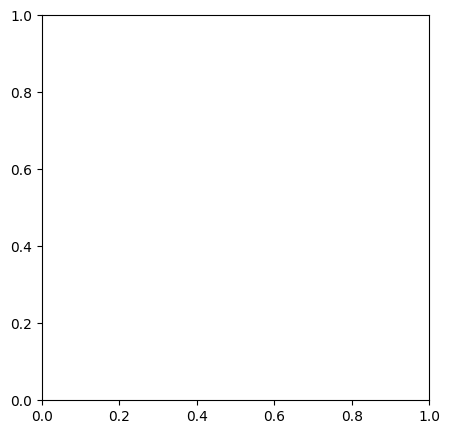

In [81]:
list_of_fet = list(list_of_fet)

fig, ax = plt.subplots(figsize=(5,5))

for _ in range(1):
    matrix = []
    
    for i in range(len(list_of_fet)):
        lst = list_of_fet.copy()
        fet = lst.pop(i)
        
        ans, loss, loss_mean = train_and_test(lst, 500, .2)
        print(i, ans, loss, loss_mean)
        
        matrix.append((ans, fet))
        
    
        
    history1.append((ans, fet))
    matrix.sort(key=lambda x: -x[0])
    matrix = matrix[:-5]
    
    list_of_fet = []
    for _, x in matrix:
        list_of_fet.append(x)
        
    ans, loss, loss_mean = train_and_test(list_of_fet)
    history.append([ans, loss, loss_mean])

In [82]:
history

[[30.786907196044922, 3.4646265536654856e-08, 27573.298936445808],
 [34.55529022216797, 3.2722646207807014e-08, 26768.11809089432],
 [30.12510108947754, 3.563449064019196e-08, 29421.025648762494],
 [32.48299789428711, 3.548104555917323e-08, 29659.738604450144],
 [26.250484466552734, 3.5523278048775376e-08, 30661.309905996564]]

In [83]:
list_of_fet

[array([7.e-07, 4.e-07]),
 array([9.e-07, 8.e-07]),
 array([8.e-07, 5.e-07]),
 array([3.e-07, 9.e-07]),
 array([4.e-07, 1.e-06]),
 array([6.e-07, 6.e-07]),
 array([7.e-07, 7.e-07]),
 array([3.e-07, 8.e-07]),
 array([9.e-07, 6.e-07]),
 array([3.e-07, 4.e-07]),
 array([2.e-07, 3.e-07]),
 array([3.e-07, 2.e-07]),
 array([5.e-07, 2.e-07]),
 array([4.e-07, 4.e-07]),
 array([4.e-07, 3.e-07]),
 array([2.e-07, 4.e-07]),
 array([5.e-07, 5.e-07]),
 array([5.e-07, 1.e-06]),
 array([3.e-07, 6.e-07]),
 array([2.e-07, 2.e-07]),
 array([5.e-07, 4.e-07]),
 array([5.e-07, 6.e-07]),
 array([6.e-07, 5.e-07]),
 array([3.e-07, 3.e-07]),
 array([1.e-06, 1.e-06]),
 array([9.e-07, 1.e-06]),
 array([9.e-07, 7.e-07]),
 array([8.e-07, 9.e-07]),
 array([7.e-07, 6.e-07]),
 array([6.e-07, 4.e-07]),
 array([3.e-07, 1.e-06]),
 array([4.e-07, 8.e-07]),
 array([3.e-07, 7.e-07]),
 array([1.e-06, 9.e-07]),
 array([9.e-07, 9.e-07]),
 array([7.e-07, 5.e-07]),
 array([8.e-07, 7.e-07]),
 array([6.e-07, 2.e-07]),
 array([1.e-

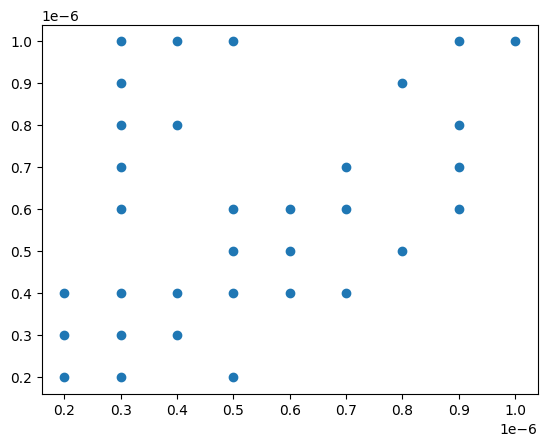

In [97]:
list_of_fet = np.array(list_of_fet)

plt.scatter(list_of_fet[:, 0], list_of_fet[:, 1])

In [86]:
matrix.sort(key=lambda x: -x[0])
# print(matrix)
matrix = matrix[:-10]
    
list_of_fet = []
for _, x in matrix:
    list_of_fet.append(x)

In [87]:
train_and_test(list_of_fet)

100%|████████████████████████████████████████████████████████████████████████████████| 693/693 [00:21<00:00, 32.07it/s]


Learning
4/4 [==============================] - 0s 4ms/step - loss: 24.2511 - mse: 0.0943
Testing
17403/17403 [==============================] - 32s 2ms/step
Loss train: 24.25107192993164, MSE: 3.1993615502043086e-08, MAPE: 31085.9435392322


(24.25107192993164, 3.1993615502043086e-08, 31085.9435392322)

In [99]:
len(list_of_fet)

33

100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:17<00:00, 37.61it/s]


Learning
4/4 [==============================] - 0s 4ms/step - loss: 23.3491 - mse: 0.0945
Testing
3481/3481 [==============================] - 6s 2ms/step
Loss train: 23.349050521850586, MSE: 3.020748585685742e-08, MAPE: 29195.243944605183
0 23.349050521850586 3.020748585685742e-08 29195.243944605183


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:20<00:00, 32.49it/s]


Learning
4/4 [==============================] - 0s 4ms/step - loss: 23.6712 - mse: 0.0944
Testing
3481/3481 [==============================] - 6s 2ms/step
Loss train: 23.671192169189453, MSE: 3.048787836763046e-08, MAPE: 29533.038486889167
1 23.671192169189453 3.048787836763046e-08 29533.038486889167


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:21<00:00, 30.65it/s]


Learning
4/4 [==============================] - 0s 4ms/step - loss: 23.9715 - mse: 0.0952
Testing
3481/3481 [==============================] - 7s 2ms/step
Loss train: 23.971454620361328, MSE: 2.863808505972757e-08, MAPE: 27416.784437923972
2 23.971454620361328 2.863808505972757e-08 27416.784437923972


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:19<00:00, 34.00it/s]


Learning
4/4 [==============================] - 0s 4ms/step - loss: 23.2596 - mse: 0.0949
Testing
3481/3481 [==============================] - 7s 2ms/step
Loss train: 23.2596435546875, MSE: 3.130203743434217e-08, MAPE: 28991.680797865014
3 23.2596435546875 3.130203743434217e-08 28991.680797865014


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:20<00:00, 33.43it/s]


Learning
4/4 [==============================] - 0s 4ms/step - loss: 23.4551 - mse: 0.0936
Testing
3481/3481 [==============================] - 7s 2ms/step
Loss train: 23.45511245727539, MSE: 2.9919221202176884e-08, MAPE: 27707.99237519279
4 23.45511245727539 2.9919221202176884e-08 27707.99237519279


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:17<00:00, 37.44it/s]


Learning
4/4 [==============================] - 0s 4ms/step - loss: 24.3673 - mse: 0.0977
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 24.367311477661133, MSE: 2.9253377849416185e-08, MAPE: 28414.86873763869
5 24.367311477661133 2.9253377849416185e-08 28414.86873763869


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:20<00:00, 32.06it/s]


Learning
4/4 [==============================] - 0s 4ms/step - loss: 23.7736 - mse: 0.0950
Testing
3481/3481 [==============================] - 6s 2ms/step
Loss train: 23.773632049560547, MSE: 2.9581528204025284e-08, MAPE: 28490.866450567595
6 23.773632049560547 2.9581528204025284e-08 28490.866450567595


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:19<00:00, 34.06it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 23.0227 - mse: 0.0938
Testing
3481/3481 [==============================] - 5s 1ms/step
Loss train: 23.022714614868164, MSE: 3.0669031288148745e-08, MAPE: 28468.04502652129
7 23.022714614868164 3.0669031288148745e-08 28468.04502652129


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:21<00:00, 31.86it/s]


Learning
4/4 [==============================] - 0s 4ms/step - loss: 24.2137 - mse: 0.0980
Testing
3481/3481 [==============================] - 5s 1ms/step
Loss train: 24.213668823242188, MSE: 2.9576670057780275e-08, MAPE: 29347.9581591606
8 24.213668823242188 2.9576670057780275e-08 29347.9581591606


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:19<00:00, 34.77it/s]


Learning
4/4 [==============================] - 0s 4ms/step - loss: 24.7124 - mse: 0.0981
Testing
3481/3481 [==============================] - 6s 2ms/step
Loss train: 24.712411880493164, MSE: 2.999901135134373e-08, MAPE: 28526.600911137153
9 24.712411880493164 2.999901135134373e-08 28526.600911137153


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:18<00:00, 35.97it/s]


Learning
4/4 [==============================] - 0s 4ms/step - loss: 25.0004 - mse: 0.0990
Testing
3481/3481 [==============================] - 6s 2ms/step
Loss train: 25.000442504882812, MSE: 2.8556113209342996e-08, MAPE: 27368.27950972126
10 25.000442504882812 2.8556113209342996e-08 27368.27950972126


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:18<00:00, 35.55it/s]


Learning
4/4 [==============================] - 0s 5ms/step - loss: 23.7816 - mse: 0.0979
Testing
3481/3481 [==============================] - 5s 1ms/step
Loss train: 23.78156089782715, MSE: 2.854182045360823e-08, MAPE: 27474.09249691845
11 23.78156089782715 2.854182045360823e-08 27474.09249691845


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:19<00:00, 34.65it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 23.3298 - mse: 0.0973
Testing
3481/3481 [==============================] - 5s 1ms/step
Loss train: 23.329837799072266, MSE: 2.9175441792058117e-08, MAPE: 28767.324077979178
12 23.329837799072266 2.9175441792058117e-08 28767.324077979178


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:17<00:00, 37.89it/s]


Learning
4/4 [==============================] - 0s 4ms/step - loss: 24.1000 - mse: 0.0988
Testing
3481/3481 [==============================] - 8s 2ms/step
Loss train: 24.10000991821289, MSE: 2.9422934652333537e-08, MAPE: 28221.748315137193
13 24.10000991821289 2.9422934652333537e-08 28221.748315137193


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:25<00:00, 26.32it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 23.7805 - mse: 0.0957
Testing
3481/3481 [==============================] - 5s 2ms/step
Loss train: 23.780506134033203, MSE: 3.013609558590816e-08, MAPE: 29256.555939400085
14 23.780506134033203 3.013609558590816e-08 29256.555939400085


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:17<00:00, 39.42it/s]


Learning
4/4 [==============================] - 0s 4ms/step - loss: 24.6873 - mse: 0.0971
Testing
3481/3481 [==============================] - 6s 2ms/step
Loss train: 24.687305450439453, MSE: 3.0934918014299854e-08, MAPE: 29563.301753834032
15 24.687305450439453 3.0934918014299854e-08 29563.301753834032


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:21<00:00, 31.90it/s]


Learning
4/4 [==============================] - 0s 4ms/step - loss: 24.0855 - mse: 0.0986
Testing
3481/3481 [==============================] - 6s 2ms/step
Loss train: 24.085521697998047, MSE: 2.9522253896791536e-08, MAPE: 28272.70560203064
16 24.085521697998047 2.9522253896791536e-08 28272.70560203064


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:18<00:00, 36.93it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 24.3371 - mse: 0.0970
Testing
3481/3481 [==============================] - 5s 1ms/step
Loss train: 24.337081909179688, MSE: 2.98654143072124e-08, MAPE: 28902.63708158389
17 24.337081909179688 2.98654143072124e-08 28902.63708158389


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:17<00:00, 37.73it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 24.3256 - mse: 0.0986
Testing
3481/3481 [==============================] - 5s 2ms/step
Loss train: 24.325597763061523, MSE: 2.9563326163961692e-08, MAPE: 27722.44434775157
18 24.325597763061523 2.9563326163961692e-08 27722.44434775157


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:19<00:00, 34.74it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 24.2685 - mse: 0.1028
Testing
3481/3481 [==============================] - 4s 1ms/step
Loss train: 24.268529891967773, MSE: 2.9536156810384363e-08, MAPE: 28088.460292174397
19 24.268529891967773 2.9536156810384363e-08 28088.460292174397


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:16<00:00, 40.05it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 24.4156 - mse: 0.0977
Testing
3481/3481 [==============================] - 4s 1ms/step
Loss train: 24.41556739807129, MSE: 2.9056089910048672e-08, MAPE: 28207.088871747055
20 24.41556739807129 2.9056089910048672e-08 28207.088871747055


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:16<00:00, 40.06it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 24.3774 - mse: 0.1003
Testing
3481/3481 [==============================] - 5s 1ms/step
Loss train: 24.377363204956055, MSE: 2.9398854596566073e-08, MAPE: 27903.39859465191
21 24.377363204956055 2.9398854596566073e-08 27903.39859465191


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:16<00:00, 39.82it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 25.1254 - mse: 0.1034
Testing
3481/3481 [==============================] - 5s 1ms/step
Loss train: 25.125350952148438, MSE: 3.0248684879925924e-08, MAPE: 29321.530090284654
22 25.125350952148438 3.0248684879925924e-08 29321.530090284654


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:16<00:00, 39.57it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 24.2911 - mse: 0.1004
Testing
3481/3481 [==============================] - 5s 1ms/step
Loss train: 24.291059494018555, MSE: 2.9055912850282292e-08, MAPE: 27939.213506676984
23 24.291059494018555 2.9055912850282292e-08 27939.213506676984


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:17<00:00, 38.89it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 24.4005 - mse: 0.0961
Testing
3481/3481 [==============================] - 5s 1ms/step
Loss train: 24.400493621826172, MSE: 3.065802587470814e-08, MAPE: 30141.22283655947
24 24.400493621826172 3.065802587470814e-08 30141.22283655947


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:16<00:00, 39.71it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 23.9065 - mse: 0.0980
Testing
3481/3481 [==============================] - 4s 1ms/step
Loss train: 23.906490325927734, MSE: 3.0487102919645554e-08, MAPE: 29334.819968179945
25 23.906490325927734 3.0487102919645554e-08 29334.819968179945


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:16<00:00, 39.87it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 24.1497 - mse: 0.0972
Testing
3481/3481 [==============================] - 4s 1ms/step
Loss train: 24.149723052978516, MSE: 3.037985076875777e-08, MAPE: 29998.89207316507
26 24.149723052978516 3.037985076875777e-08 29998.89207316507


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:17<00:00, 38.99it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 25.2351 - mse: 0.0998
Testing
3481/3481 [==============================] - 5s 2ms/step
Loss train: 25.23508071899414, MSE: 2.899882842346155e-08, MAPE: 28491.902705212487
27 25.23508071899414 2.899882842346155e-08 28491.902705212487


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:17<00:00, 39.05it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 24.8345 - mse: 0.1001
Testing
3481/3481 [==============================] - 5s 2ms/step
Loss train: 24.834470748901367, MSE: 2.9419228556661067e-08, MAPE: 28818.702372486612
28 24.834470748901367 2.9419228556661067e-08 28818.702372486612


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:17<00:00, 39.01it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 23.9526 - mse: 0.0969
Testing
3481/3481 [==============================] - 5s 2ms/step
Loss train: 23.952632904052734, MSE: 2.9692432275157396e-08, MAPE: 28665.764652323105
29 23.952632904052734 2.9692432275157396e-08 28665.764652323105


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:17<00:00, 38.12it/s]


Learning
4/4 [==============================] - 0s 4ms/step - loss: 23.4763 - mse: 0.0987
Testing
3481/3481 [==============================] - 5s 1ms/step
Loss train: 23.47626495361328, MSE: 3.180727631493544e-08, MAPE: 29866.161543561964
30 23.47626495361328 3.180727631493544e-08 29866.161543561964


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:17<00:00, 38.86it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 23.9458 - mse: 0.0982
Testing
3481/3481 [==============================] - 4s 1ms/step
Loss train: 23.945758819580078, MSE: 3.023399691005782e-08, MAPE: 28480.120924323106
31 23.945758819580078 3.023399691005782e-08 28480.120924323106


100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:17<00:00, 38.81it/s]


Learning
4/4 [==============================] - 0s 3ms/step - loss: 23.4978 - mse: 0.0975
Testing
3481/3481 [==============================] - 5s 2ms/step
Loss train: 23.497785568237305, MSE: 3.013285494892613e-08, MAPE: 28755.773212072232
32 23.497785568237305 3.013285494892613e-08 28755.773212072232


100%|████████████████████████████████████████████████████████████████████████████████| 588/588 [00:15<00:00, 38.90it/s]


Learning
4/4 [==============================] - 0s 4ms/step - loss: 20.8423 - mse: 0.0781
Testing
17403/17403 [==============================] - 25s 1ms/step
Loss train: 20.84231185913086, MSE: 3.241110894477414e-08, MAPE: 29475.753135132858


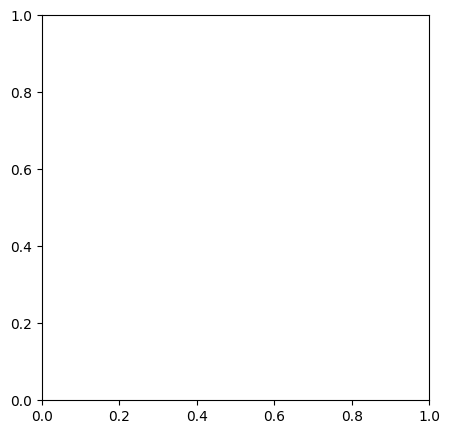

In [100]:
list_of_fet = list(list_of_fet)

fig, ax = plt.subplots(figsize=(5,5))

for _ in range(1):
    matrix = []
    
    for i in range(len(list_of_fet)):
        lst = list_of_fet.copy()
        fet = lst.pop(i)
        
        ans, loss, loss_mean = train_and_test(lst, 500, .2)
        print(i, ans, loss, loss_mean)
        
        matrix.append((ans, fet))
        
    
        
    history1.append((ans, fet))
    matrix.sort(key=lambda x: -x[0])
    matrix = matrix[:-5]
    
    list_of_fet = []
    for _, x in matrix:
        list_of_fet.append(x)
        
    ans, loss, loss_mean = train_and_test(list_of_fet)
    history.append([ans, loss, loss_mean])

In [101]:
history

[[30.786907196044922, 3.4646265536654856e-08, 27573.298936445808],
 [34.55529022216797, 3.2722646207807014e-08, 26768.11809089432],
 [30.12510108947754, 3.563449064019196e-08, 29421.025648762494],
 [32.48299789428711, 3.548104555917323e-08, 29659.738604450144],
 [26.250484466552734, 3.5523278048775376e-08, 30661.309905996564],
 [20.84231185913086, 3.241110894477414e-08, 29475.753135132858]]

In [102]:
list_of_fet

[array([8.e-07, 9.e-07]),
 array([6.e-07, 5.e-07]),
 array([2.e-07, 3.e-07]),
 array([7.e-07, 6.e-07]),
 array([3.e-07, 4.e-07]),
 array([2.e-07, 4.e-07]),
 array([5.e-07, 4.e-07]),
 array([1.e-06, 1.e-06]),
 array([5.e-07, 6.e-07]),
 array([6.e-07, 6.e-07]),
 array([5.e-07, 1.e-06]),
 array([3.e-07, 6.e-07]),
 array([3.e-07, 3.e-07]),
 array([2.e-07, 2.e-07]),
 array([9.e-07, 6.e-07]),
 array([9.e-07, 7.e-07]),
 array([4.e-07, 4.e-07]),
 array([5.e-07, 5.e-07]),
 array([8.e-07, 5.e-07]),
 array([6.e-07, 4.e-07]),
 array([4.e-07, 8.e-07]),
 array([9.e-07, 1.e-06]),
 array([3.e-07, 2.e-07]),
 array([4.e-07, 3.e-07]),
 array([7.e-07, 7.e-07]),
 array([9.e-07, 8.e-07]),
 array([3.e-07, 7.e-07]),
 array([3.e-07, 1.e-06])]

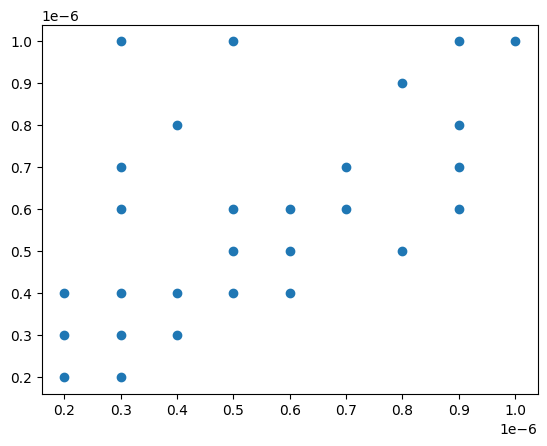

In [103]:
list_of_fet = np.array(list_of_fet)

plt.scatter(list_of_fet[:, 0], list_of_fet[:, 1])

In [104]:
train_and_test(list_of_fet)

100%|████████████████████████████████████████████████████████████████████████████████| 588/588 [00:15<00:00, 37.73it/s]


Learning
4/4 [==============================] - 0s 4ms/step - loss: 20.2043 - mse: 0.0770
Testing
17403/17403 [==============================] - 35s 2ms/step
Loss train: 20.204328536987305, MSE: 3.246361363269793e-08, MAPE: 30213.360547550972


(20.204328536987305, 3.246361363269793e-08, 30213.360547550972)

In [105]:
matrix.sort(key=lambda x: -x[0])
# print(matrix)
    
list_of_fet = []
for _, x in matrix[:-10]:
    list_of_fet.append(x)

In [106]:
train_and_test(list_of_fet)

100%|████████████████████████████████████████████████████████████████████████████████| 378/378 [00:09<00:00, 38.02it/s]


Learning
3/3 [==============================] - 0s 4ms/step - loss: 18.0412 - mse: 0.0901
Testing
17403/17403 [==============================] - 27s 2ms/step
Loss train: 18.041200637817383, MSE: 3.502344313022511e-08, MAPE: 30720.919488681484


(18.041200637817383, 3.502344313022511e-08, 30720.919488681484)

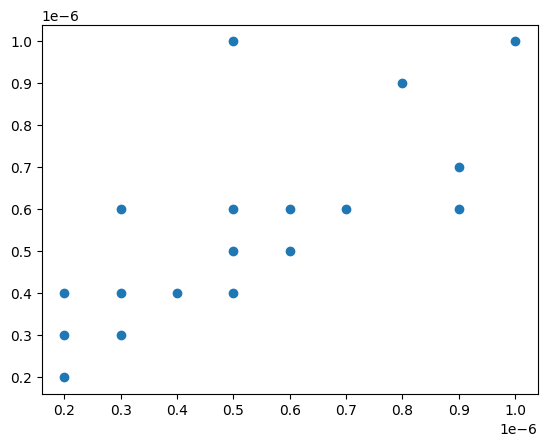

In [107]:
list_of_fet = np.array(list_of_fet)

plt.scatter(list_of_fet[:, 0], list_of_fet[:, 1])

100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 37.94it/s]


Learning
2/2 [==============================] - 0s 5ms/step - loss: 20.6572 - mse: 0.1096
Testing
3481/3481 [==============================] - 5s 2ms/step
Loss train: 20.65715217590332, MSE: 2.909063509117736e-08, MAPE: 27113.649180524142
0 20.65715217590332 2.909063509117736e-08 27113.649180524142


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 36.31it/s]


Learning
2/2 [==============================] - 0s 4ms/step - loss: 19.6163 - mse: 0.0980
Testing
3481/3481 [==============================] - 6s 2ms/step
Loss train: 19.616336822509766, MSE: 3.3024707694359655e-08, MAPE: 28017.211667025404
1 19.616336822509766 3.3024707694359655e-08 28017.211667025404


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 38.50it/s]


Learning
2/2 [==============================] - 0s 5ms/step - loss: 20.0108 - mse: 0.0993
Testing
3481/3481 [==============================] - 5s 1ms/step
Loss train: 20.010766983032227, MSE: 3.11737194985123e-08, MAPE: 26584.441077081316
2 20.010766983032227 3.11737194985123e-08 26584.441077081316


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 37.75it/s]


Learning
2/2 [==============================] - 0s 3ms/step - loss: 18.9356 - mse: 0.1025
Testing
3481/3481 [==============================] - 4s 1ms/step
Loss train: 18.935569763183594, MSE: 3.028627631864077e-08, MAPE: 25810.329821287578
3 18.935569763183594 3.028627631864077e-08 25810.329821287578


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 38.53it/s]


Learning
2/2 [==============================] - 0s 4ms/step - loss: 19.6781 - mse: 0.1053
Testing
3481/3481 [==============================] - 4s 1ms/step
Loss train: 19.67807388305664, MSE: 3.2514224269958117e-08, MAPE: 26582.279385911705
4 19.67807388305664 3.2514224269958117e-08 26582.279385911705


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 38.20it/s]


Learning
2/2 [==============================] - 0s 4ms/step - loss: 18.3972 - mse: 0.1033
Testing
3481/3481 [==============================] - 7s 2ms/step
Loss train: 18.397172927856445, MSE: 3.197089268935209e-08, MAPE: 25810.326860253885
5 18.397172927856445 3.197089268935209e-08 25810.326860253885


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 36.38it/s]


Learning
2/2 [==============================] - 0s 4ms/step - loss: 18.9305 - mse: 0.1032
Testing
3481/3481 [==============================] - 4s 1ms/step
Loss train: 18.930526733398438, MSE: 3.2547775106835166e-08, MAPE: 26848.79069795788
6 18.930526733398438 3.2547775106835166e-08 26848.79069795788


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 37.70it/s]


Learning
2/2 [==============================] - 0s 5ms/step - loss: 18.3879 - mse: 0.0987
Testing
3481/3481 [==============================] - 6s 2ms/step
Loss train: 18.3879337310791, MSE: 3.1019577122047955e-08, MAPE: 28408.984025073467
7 18.3879337310791 3.1019577122047955e-08 28408.984025073467


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 37.99it/s]


Learning
2/2 [==============================] - 0s 4ms/step - loss: 19.9449 - mse: 0.1099
Testing
3481/3481 [==============================] - 4s 1ms/step
Loss train: 19.944883346557617, MSE: 3.2826063813209865e-08, MAPE: 28082.60607742489
8 19.944883346557617 3.2826063813209865e-08 28082.60607742489


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 36.76it/s]


Learning
2/2 [==============================] - 0s 5ms/step - loss: 19.4343 - mse: 0.1070
Testing
3481/3481 [==============================] - 5s 2ms/step
Loss train: 19.434268951416016, MSE: 3.072046122555044e-08, MAPE: 28172.056837886234
9 19.434268951416016 3.072046122555044e-08 28172.056837886234


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 37.92it/s]


Learning
2/2 [==============================] - 0s 5ms/step - loss: 18.0691 - mse: 0.0975
Testing
3481/3481 [==============================] - 4s 1ms/step
Loss train: 18.069128036499023, MSE: 3.8357027356464534e-08, MAPE: 31125.025108408474
10 18.069128036499023 3.8357027356464534e-08 31125.025108408474


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 38.14it/s]


Learning
2/2 [==============================] - 0s 4ms/step - loss: 18.6903 - mse: 0.1029
Testing
3481/3481 [==============================] - 5s 1ms/step
Loss train: 18.69027328491211, MSE: 3.241513832129571e-08, MAPE: 26154.133215575017
11 18.69027328491211 3.241513832129571e-08 26154.133215575017


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 38.66it/s]


Learning
2/2 [==============================] - 0s 4ms/step - loss: 18.2955 - mse: 0.1016
Testing
3481/3481 [==============================] - 4s 1ms/step
Loss train: 18.29545783996582, MSE: 3.1026076116977e-08, MAPE: 26123.650284964497
12 18.29545783996582 3.1026076116977e-08 26123.650284964497


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 38.47it/s]


Learning
2/2 [==============================] - 0s 5ms/step - loss: 18.5129 - mse: 0.1002
Testing
3481/3481 [==============================] - 5s 1ms/step
Loss train: 18.512853622436523, MSE: 3.190191719712583e-08, MAPE: 25641.96546369848
13 18.512853622436523 3.190191719712583e-08 25641.96546369848


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 38.46it/s]


Learning
2/2 [==============================] - 0s 4ms/step - loss: 18.1360 - mse: 0.1021
Testing
3481/3481 [==============================] - 4s 1ms/step
Loss train: 18.13596534729004, MSE: 3.027143081204321e-08, MAPE: 26838.235234731408
14 18.13596534729004 3.027143081204321e-08 26838.235234731408


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 38.35it/s]


Learning
2/2 [==============================] - 0s 4ms/step - loss: 18.1307 - mse: 0.1008
Testing
3481/3481 [==============================] - 5s 1ms/step
Loss train: 18.130708694458008, MSE: 3.04796614436957e-08, MAPE: 27036.68435272562
15 18.130708694458008 3.04796614436957e-08 27036.68435272562


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 37.25it/s]


Learning
2/2 [==============================] - 0s 4ms/step - loss: 18.4247 - mse: 0.0980
Testing
3481/3481 [==============================] - 4s 1ms/step
Loss train: 18.424718856811523, MSE: 3.2699807985632535e-08, MAPE: 27091.95562951713
16 18.424718856811523 3.2699807985632535e-08 27091.95562951713


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 38.08it/s]


Learning
2/2 [==============================] - 0s 4ms/step - loss: 18.5483 - mse: 0.0988
Testing
3481/3481 [==============================] - 5s 1ms/step
Loss train: 18.54825210571289, MSE: 3.174540003381924e-08, MAPE: 27707.118934573915
17 18.54825210571289 3.174540003381924e-08 27707.118934573915


100%|████████████████████████████████████████████████████████████████████████████████| 273/273 [00:07<00:00, 38.14it/s]


Learning
2/2 [==============================] - 0s 5ms/step - loss: 17.0694 - mse: 0.0896
Testing
17403/17403 [==============================] - 20s 1ms/step
Loss train: 17.06942367553711, MSE: 3.622204892263093e-08, MAPE: 35992.9833826928


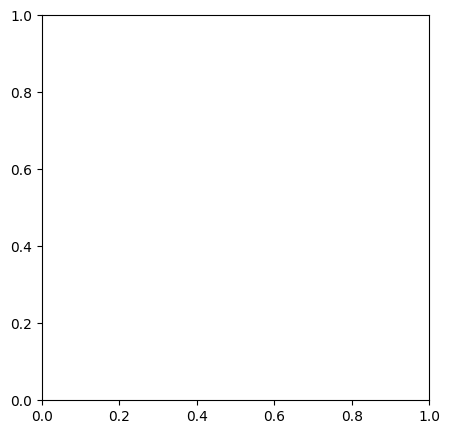

In [110]:
list_of_fet = list(list_of_fet)

fig, ax = plt.subplots(figsize=(5,5))

for _ in range(1):
    matrix = []
    
    for i in range(len(list_of_fet)):
        lst = list_of_fet.copy()
        fet = lst.pop(i)
        
        ans, loss, loss_mean = train_and_test(lst, 500, .2)
        print(i, ans, loss, loss_mean)
        
        matrix.append((ans, fet))
        
    
        
    history1.append((ans, fet))
    matrix.sort(key=lambda x: -x[0])
    matrix = matrix[:-5]
    
    list_of_fet = []
    for _, x in matrix:
        list_of_fet.append(x)
        
    ans, loss, loss_mean = train_and_test(list_of_fet)
    history.append([ans, loss, loss_mean])

In [111]:
history

[[30.786907196044922, 3.4646265536654856e-08, 27573.298936445808],
 [34.55529022216797, 3.2722646207807014e-08, 26768.11809089432],
 [30.12510108947754, 3.563449064019196e-08, 29421.025648762494],
 [32.48299789428711, 3.548104555917323e-08, 29659.738604450144],
 [26.250484466552734, 3.5523278048775376e-08, 30661.309905996564],
 [20.84231185913086, 3.241110894477414e-08, 29475.753135132858],
 [17.06942367553711, 3.622204892263093e-08, 35992.9833826928]]

In [135]:
matrix

[(20.65715217590332, array([8.e-07, 9.e-07])),
 (20.010766983032227, array([2.e-07, 3.e-07])),
 (19.944883346557617, array([5.e-07, 6.e-07])),
 (19.67807388305664, array([3.e-07, 4.e-07])),
 (19.616336822509766, array([6.e-07, 5.e-07])),
 (19.434268951416016, array([6.e-07, 6.e-07])),
 (18.935569763183594, array([7.e-07, 6.e-07])),
 (18.930526733398438, array([5.e-07, 4.e-07])),
 (18.69027328491211, array([3.e-07, 6.e-07])),
 (18.54825210571289, array([5.e-07, 5.e-07])),
 (18.512853622436523, array([2.e-07, 2.e-07])),
 (18.424718856811523, array([4.e-07, 4.e-07])),
 (18.397172927856445, array([2.e-07, 4.e-07]))]

In [124]:
list_of_fet

array([[8.e-07, 9.e-07],
       [2.e-07, 3.e-07],
       [5.e-07, 6.e-07],
       [3.e-07, 4.e-07],
       [6.e-07, 5.e-07],
       [6.e-07, 6.e-07],
       [7.e-07, 6.e-07],
       [5.e-07, 4.e-07],
       [3.e-07, 6.e-07],
       [5.e-07, 5.e-07],
       [2.e-07, 2.e-07],
       [4.e-07, 4.e-07],
       [2.e-07, 4.e-07]])

In [133]:
matrix.sort(key=lambda x: -x[0])
# print(matrix)
    
list_of_fet = []
for _, x in matrix[:-3]:
    list_of_fet.append(x)

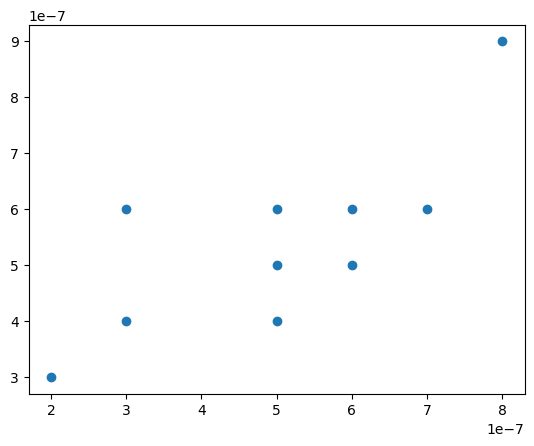

In [134]:
list_of_fet = np.array(list_of_fet)

plt.scatter(list_of_fet[:, 0], list_of_fet[:, 1])

In [136]:
len(list_of_fet)

10

100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:05<00:00, 36.44it/s]


Learning
2/2 [==============================] - 0s 5ms/step - loss: 19.9016 - mse: 0.1243
Testing
5221/5221 [==============================] - 8s 1ms/step
Loss train: 19.901643753051758, MSE: 3.178906930795573e-08, MAPE: 28603.991472498594
0 19.901643753051758 3.178906930795573e-08 28603.991472498594


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:05<00:00, 36.98it/s]


Learning
2/2 [==============================] - 0s 4ms/step - loss: 18.4218 - mse: 0.1076
Testing
5221/5221 [==============================] - 6s 1ms/step
Loss train: 18.42180633544922, MSE: 2.626952880713162e-08, MAPE: 19474.33341246512
1 18.42180633544922 2.626952880713162e-08 19474.33341246512


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:04<00:00, 38.12it/s]


Learning
2/2 [==============================] - 0s 4ms/step - loss: 19.2240 - mse: 0.1122
Testing
5221/5221 [==============================] - 7s 1ms/step
Loss train: 19.224027633666992, MSE: 3.2648539271541914e-08, MAPE: 26949.241058067655
2 19.224027633666992 3.2648539271541914e-08 26949.241058067655


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:05<00:00, 37.69it/s]


Learning
2/2 [==============================] - 0s 4ms/step - loss: 18.5189 - mse: 0.1065
Testing
5221/5221 [==============================] - 6s 1ms/step
Loss train: 18.518898010253906, MSE: 3.0106135114742284e-08, MAPE: 24313.314268086036
3 18.518898010253906 3.0106135114742284e-08 24313.314268086036


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:05<00:00, 37.16it/s]


Learning
2/2 [==============================] - 0s 4ms/step - loss: 18.4642 - mse: 0.1168
Testing
5221/5221 [==============================] - 6s 1ms/step
Loss train: 18.46417236328125, MSE: 3.243654086059745e-08, MAPE: 25862.57737899828
4 18.46417236328125 3.243654086059745e-08 25862.57737899828


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:05<00:00, 34.43it/s]


Learning
2/2 [==============================] - 0s 5ms/step - loss: 20.5794 - mse: 0.1307
Testing
5221/5221 [==============================] - 10s 2ms/step
Loss train: 20.579387664794922, MSE: 3.229697827659955e-08, MAPE: 27799.652823080854
5 20.579387664794922 3.229697827659955e-08 27799.652823080854


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:05<00:00, 35.67it/s]


Learning
2/2 [==============================] - 0s 5ms/step - loss: 18.0187 - mse: 0.1032
Testing
5221/5221 [==============================] - 7s 1ms/step
Loss train: 18.01869010925293, MSE: 3.290359111926553e-08, MAPE: 28412.83349669538
6 18.01869010925293 3.290359111926553e-08 28412.83349669538


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:05<00:00, 37.20it/s]


Learning
2/2 [==============================] - 0s 5ms/step - loss: 21.2825 - mse: 0.1341
Testing
5221/5221 [==============================] - 6s 1ms/step
Loss train: 21.282489776611328, MSE: 3.2772184965473005e-08, MAPE: 26178.0237069752
7 21.282489776611328 3.2772184965473005e-08 26178.0237069752


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:05<00:00, 35.74it/s]


Learning
2/2 [==============================] - 0s 5ms/step - loss: 16.6807 - mse: 0.1032
Testing
5221/5221 [==============================] - 6s 1ms/step
Loss train: 16.680713653564453, MSE: 3.405572446669098e-08, MAPE: 25026.5550184149
8 16.680713653564453 3.405572446669098e-08 25026.5550184149


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:05<00:00, 34.45it/s]


Learning
2/2 [==============================] - 0s 7ms/step - loss: 19.5413 - mse: 0.1209
Testing
5221/5221 [==============================] - 7s 1ms/step
Loss train: 19.541275024414062, MSE: 3.231141086390989e-08, MAPE: 26750.778763854716
9 19.541275024414062 3.231141086390989e-08 26750.778763854716


100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [00:07<00:00, 29.03it/s]


Learning
2/2 [==============================] - 0s 4ms/step - loss: 16.0423 - mse: 0.0940
Testing
17403/17403 [==============================] - 29s 2ms/step
Loss train: 16.042285919189453, MSE: 3.6108260882901965e-08, MAPE: 31468.15508112136


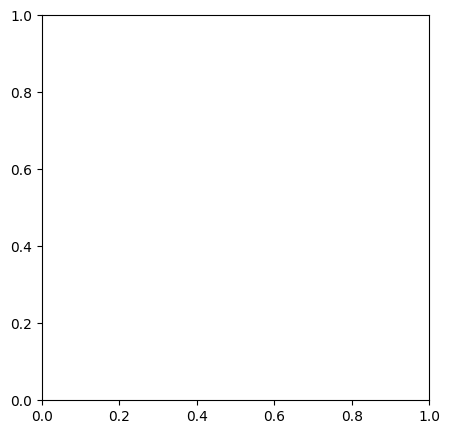

In [137]:
list_of_fet = list(list_of_fet)

fig, ax = plt.subplots(figsize=(5,5))

for _ in range(1):
    matrix = []
    
    for i in range(len(list_of_fet)):
        lst = list_of_fet.copy()
        fet = lst.pop(i)
        
        ans, loss, loss_mean = train_and_test(lst, 500, .3)
        print(i, ans, loss, loss_mean)
        
        matrix.append((ans, fet))
        
    
        
    history1.append((ans, fet))
    matrix.sort(key=lambda x: -x[0])
#     matrix = matrix[:-5]
    
#     list_of_fet = []
#     for _, x in matrix:
#         list_of_fet.append(x)
        
    ans, loss, loss_mean = train_and_test(list_of_fet)
    history.append([ans, loss, loss_mean])

In [142]:
history

[[30.786907196044922, 3.4646265536654856e-08, 27573.298936445808],
 [34.55529022216797, 3.2722646207807014e-08, 26768.11809089432],
 [30.12510108947754, 3.563449064019196e-08, 29421.025648762494],
 [32.48299789428711, 3.548104555917323e-08, 29659.738604450144],
 [26.250484466552734, 3.5523278048775376e-08, 30661.309905996564],
 [20.84231185913086, 3.241110894477414e-08, 29475.753135132858],
 [17.06942367553711, 3.622204892263093e-08, 35992.9833826928],
 [16.042285919189453, 3.6108260882901965e-08, 31468.15508112136]]

In [143]:
matrix

[(21.282489776611328, array([5.e-07, 4.e-07])),
 (20.579387664794922, array([6.e-07, 6.e-07])),
 (19.901643753051758, array([8.e-07, 9.e-07])),
 (19.541275024414062, array([5.e-07, 5.e-07])),
 (19.224027633666992, array([5.e-07, 6.e-07])),
 (18.518898010253906, array([3.e-07, 4.e-07])),
 (18.46417236328125, array([6.e-07, 5.e-07])),
 (18.42180633544922, array([2.e-07, 3.e-07])),
 (18.01869010925293, array([7.e-07, 6.e-07])),
 (16.680713653564453, array([3.e-07, 6.e-07]))]

In [146]:
matrix.sort(key=lambda x: -x[0])
# print(matrix)
    
list_of_fet = []
for _, x in matrix[:-2]:
    list_of_fet.append(x)

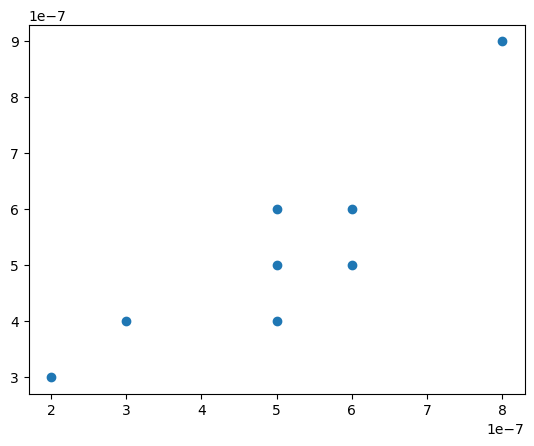

In [147]:
list_of_fet = np.array(list_of_fet)

plt.scatter(list_of_fet[:, 0], list_of_fet[:, 1])

In [148]:
train_and_test(list_of_fet)

100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:04<00:00, 36.65it/s]


Learning
1/1 [==============================] - 0s 113ms/step - loss: 16.6562 - mse: 0.1148
Testing
17403/17403 [==============================] - 27s 2ms/step
Loss train: 16.656200408935547, MSE: 3.838476558626884e-08, MAPE: 32585.966293099595


(16.656200408935547, 3.838476558626884e-08, 32585.966293099595)